# Correlation analysis using deltas (definitive version)

In this notebook we study the correlation between the burned area during the fire season's months and some climate indices for each cluster that has unimodal fire season. We used delta time series instead of the traditional time series used in the "Correlation_Per75_v2.ipynb" notebook.

First, we consider the correlation between the sum of the burned area of the fire season's months and the average of the indices in these months. We apply that to unimodal fire seasons.

Then we consider the correlation between the sum of the burned area of the fire season's months and the average of the indices in the previous months. Firstly, we will consider the climate index delta time series of the previous month, i.e., if the fire season is May and June, we will use the data of April and May. After that, we will use the 2 previous months and 3 previous ones.

We consider the following climate indexes: NINO3.4, NAO, POLEUR, EA, EA/WR, SCAND, PNA and WP.

Some plots are shown in each section summarizing the results.

In [1]:
setwd("..")

In [2]:
source("scripts/correlation_functions.R")

Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: sp
Warning message:
"package 'sp' was built under R version 3.6.3"Loading required package: magrittr
Warning message:
"package 'magrittr' was built under R version 3.6.3"
Attaching package: 'magrittr'

The following object is masked from 'package:tidyr':

    extract

Loading required package: RColorBrewer


Loading objects:
  coast.lines


In [3]:
# Data required
load("data/Fire/ba_mon_time_series_masked.Rdata", verbose = T)
load("data/fireSeason_def_2.Rdata", verbose = T)

Loading objects:
  masked_coords
  dates
  masked_ba_series
Loading objects:
  fireSeason_def_2


## Data loading

In [4]:
nina34 = read.table("data/CPC/nina34.anom.data.txt", skip = 3, nrows = 72)
colnames(nina34) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
nina34[,-1] = (nina34[,-1] - mean(as.matrix(nina34[32:61,-1]))) / sd(as.matrix(nina34[32:61,-1]))

In [5]:
nao = read.table("data/CPC/nao_index.tim.txt", skip = 8, header = T)
nao <- nao %>% spread(MONTH,INDEX)
colnames(nao) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [6]:
poleur = read.table("data/CPC/poleur_index.tim", skip = 8, header = T)
poleur <- poleur %>% spread(MONTH,INDEX)
colnames(poleur) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [7]:
ea = read.table("data/CPC/ea_index.tim.txt", skip = 8, header = T)
ea <- ea %>% spread(MONTH,INDEX)
colnames(ea) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [8]:
eawr = read.table("data/CPC/eawr_index.tim.txt", skip = 8, header = T)
eawr <- eawr %>% spread(MONTH,INDEX)
colnames(eawr) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [9]:
pna = read.table("data/CPC/pna_index.tim.txt", skip = 8, header = T)
pna <- pna %>% spread(MONTH,INDEX)
colnames(pna) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [10]:
scand = read.table("data/CPC/scand_index.tim.txt", skip = 8, header = T)
scand <- scand %>% spread(MONTH,INDEX)
colnames(scand) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

In [11]:
wp = read.table("data/CPC/wp_index.tim.txt", skip = 8, header = T)
wp <- wp %>% spread(MONTH,INDEX)
colnames(wp) = c("Year", 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

## With no persistence

In [12]:
#' @title Get highest correlation per pixel
#' @description Function for obtaining the highest (in module) correlation of a pixel among all the significant correlations
# that its burned area has with all the climate indexes
#' @param is a row of a correlation dataframe
#' @return the value of the highest correlation
getMaxCorr <- function (row){
    if (all(is.na(row[-c(1,2)])) | sum(row[seq(4, length(row), 2)] < 0.05) < 1){
        return (NA)
    } else {
        ind = which(row[seq(4, length(row), 2)] < 0.05)
        ma = max(row[2*ind+1])
        mi = min(row[2*ind+1])
        if (abs(mi) > abs(ma)){
            return (mi)
        } else {
            return (ma)
        }
    }
}

In [13]:
#' @title Get the climate index which has the highest correlation per pixel
#' @description Function for obtaining the climate index which has the highest (in module) correlation of a pixel among all the
#' significant correlations that its burned area has with all the climate indexes
#' @param is a row of a correlation dataframe
#' @param n.indexes number of different indexes used in corr.df
#' @return the position of the index between 1 and number of the climate indexes
getIndWithMaxCorr <- function (row, n.indexes = 8){
    if (all(is.na(row[-c(1,2)])) | sum(row[seq(4, length(row), 2)] < 0.05) < 1){
        return (NA)
    } else {
        ind = which(row[seq(4, length(row), 2)] < 0.05)
        ma = max(row[2*ind+1])
        mi = min(row[2*ind+1])
        if (abs(mi) > abs(ma)){
            ind.max = which(row[seq(3, length(row)-1, 2)] == mi)
        } else {
            ind.max = which(row[seq(3, length(row)-1, 2)] == ma)
        }
        ind.max = ind.max %% n.indexes
        if (ind.max == 0){
            ind.max = n.indexes
        }
        return (ind.max)
    }
}

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

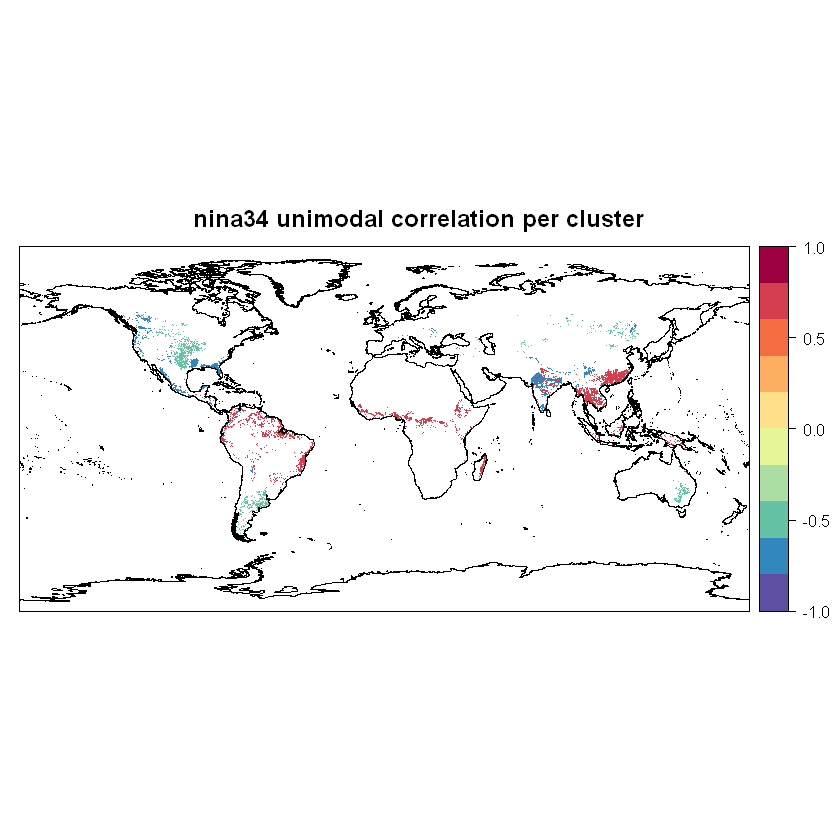

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

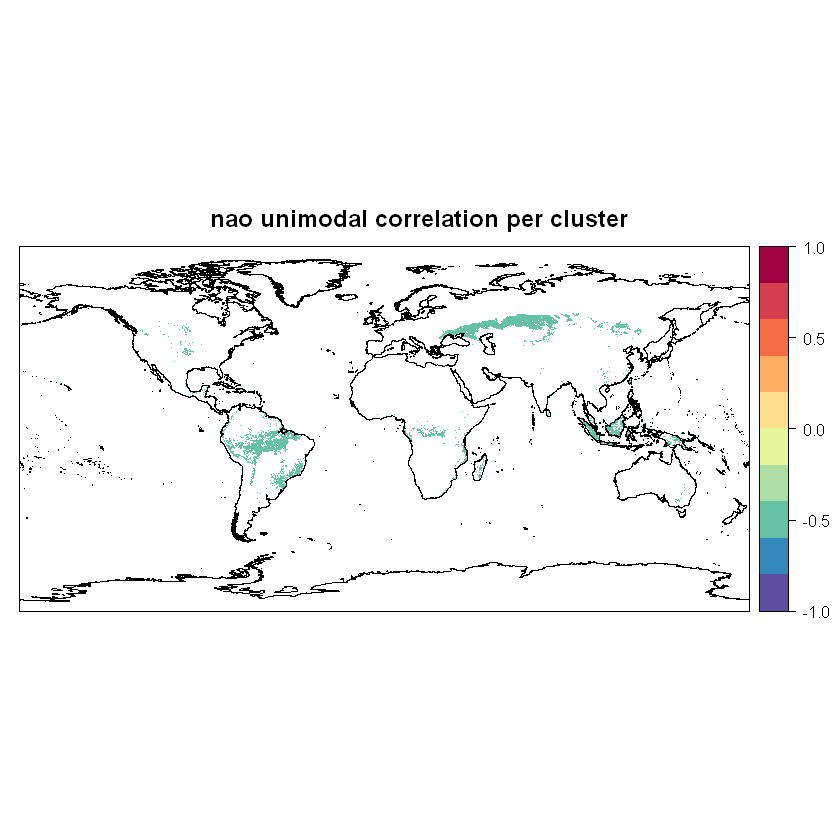

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

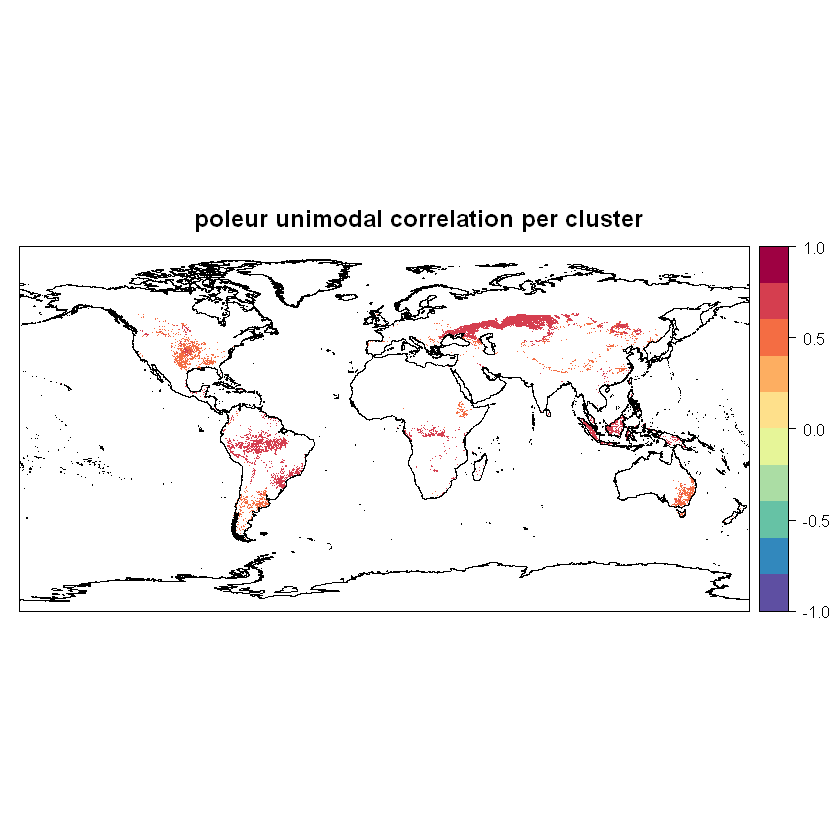

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

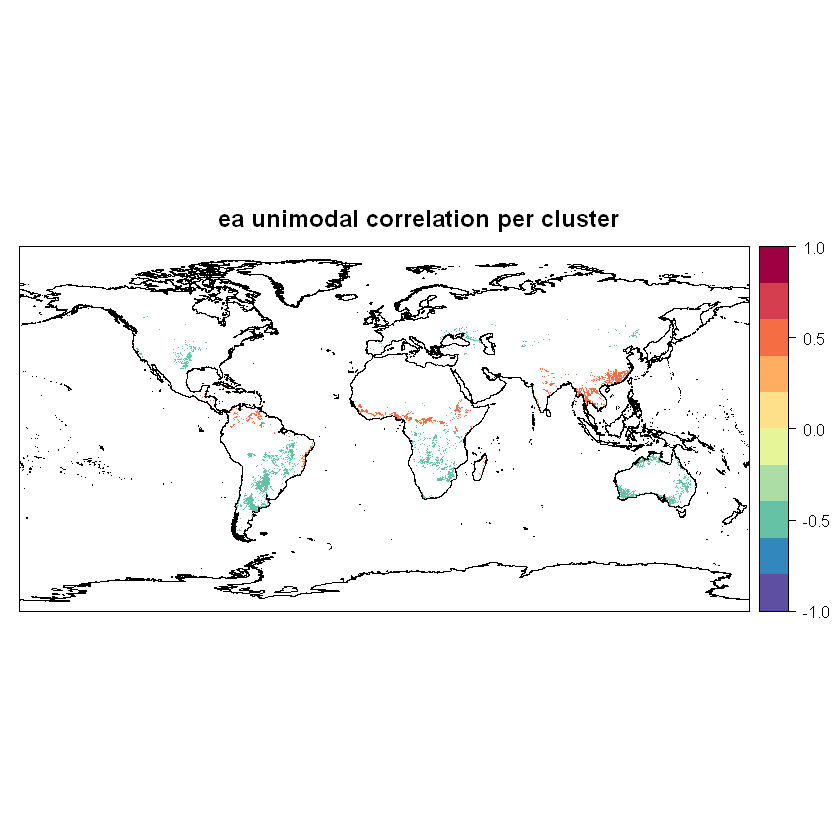

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

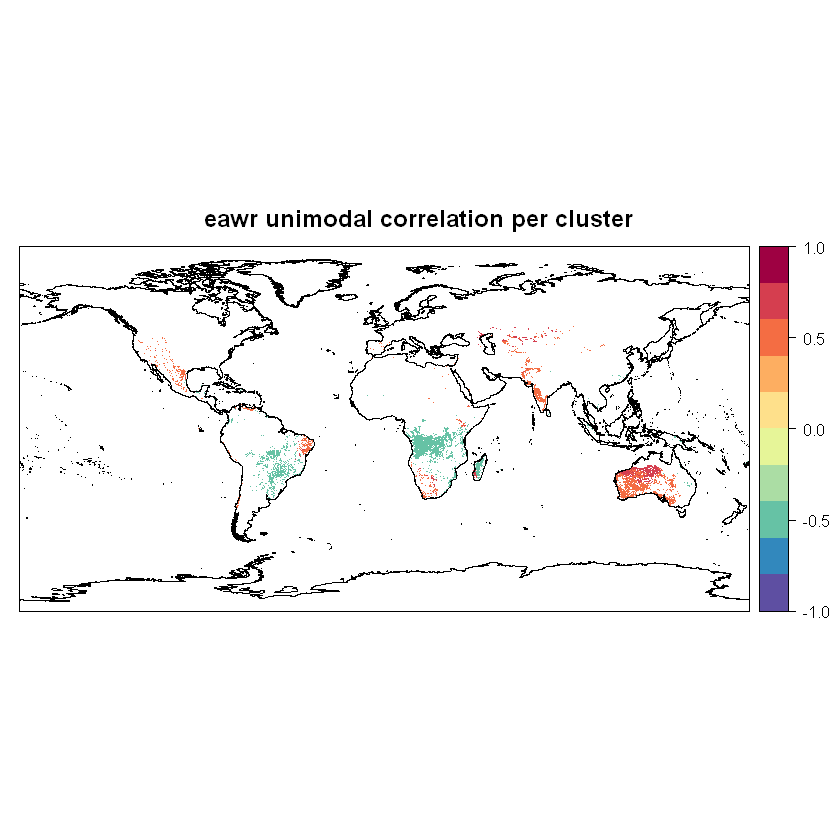

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

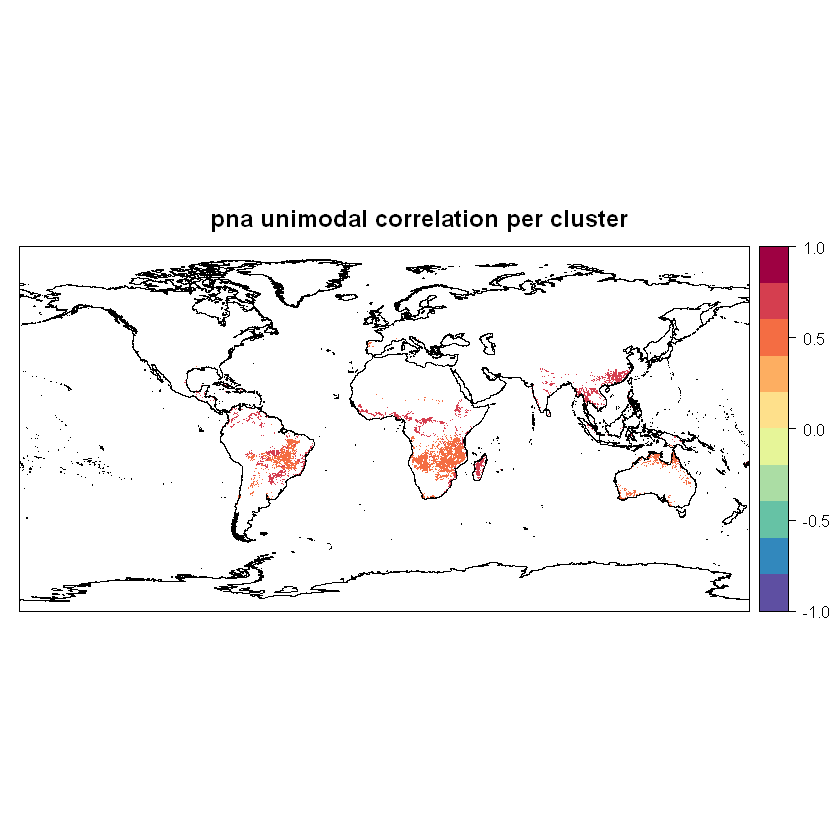

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in min(x):
"ningún argumento finito para min; retornando Inf"Warning message in max(x):
"ningun argumento finito para max; retornando -Inf"Warning message in min(x):
"ningún argumento finito para min; retornando Inf"Warning message in max(x):
"ningun argumento finito para max; retornando -Inf"

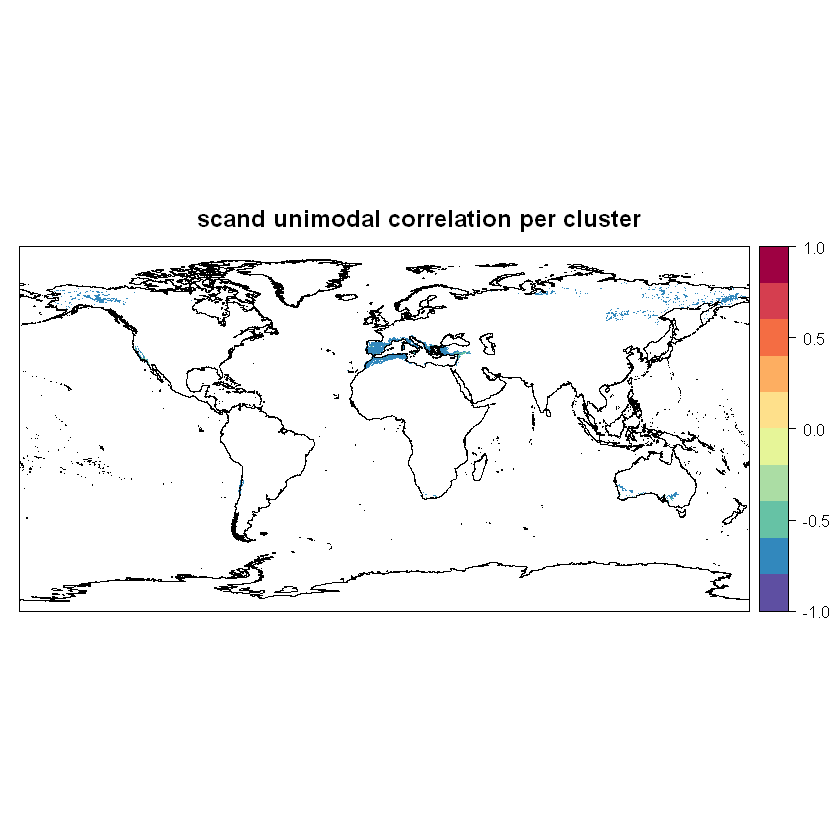

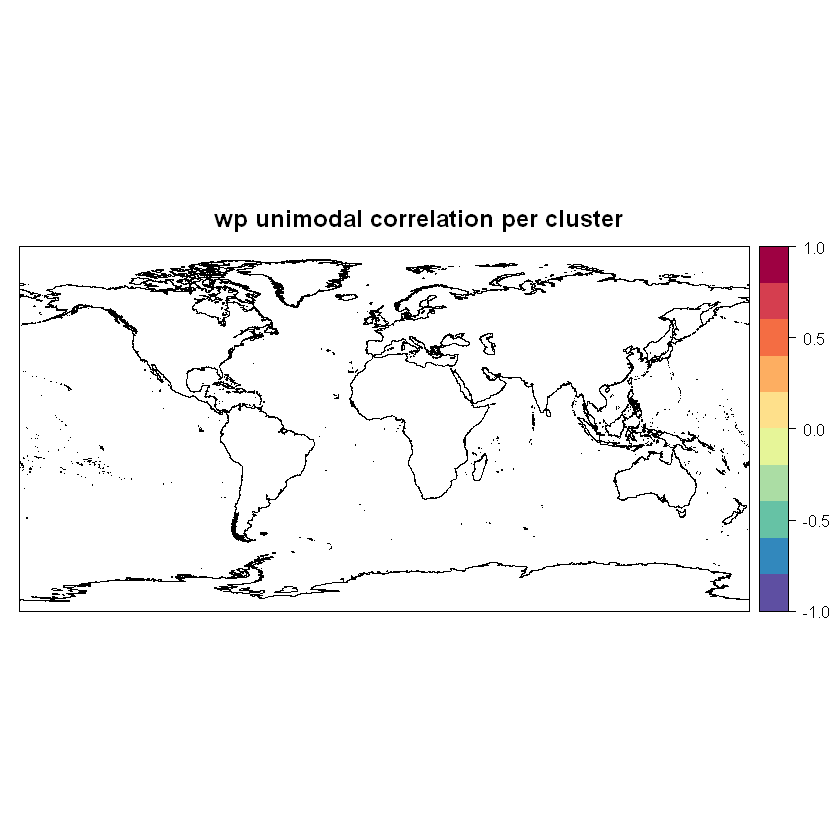

In [12]:
corr.df.delta = masked_coords
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nina34, 'nina34',
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nao, 'nao', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, poleur, 'poleur',
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, ea, 'ea', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, eawr, 'eawr', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, pna, 'pna', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, scand, 'scand', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)
corr.df.delta = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, wp, 'wp', 
                           corr.df.delta, mode = 'unimodal', useDeltas = T)

save(corr.df.delta, file = 'data/Correlation/corrDfDeltaAnnualClusV2.Rdata')

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

Number of pixels correlated with more than  0  indexes  49345 
Number of pixels correlated with more than  1  indexes  16322 
Number of pixels correlated with more than  2  indexes  2571 
Number of pixels correlated with more than  3  indexes  0 
Number of pixels correlated with more than  4  indexes  0 
Number of pixels correlated with more than  5  indexes  0 
Number of pixels correlated with more than  6  indexes  0 
Number of pixels correlated with more than  7  indexes  0 


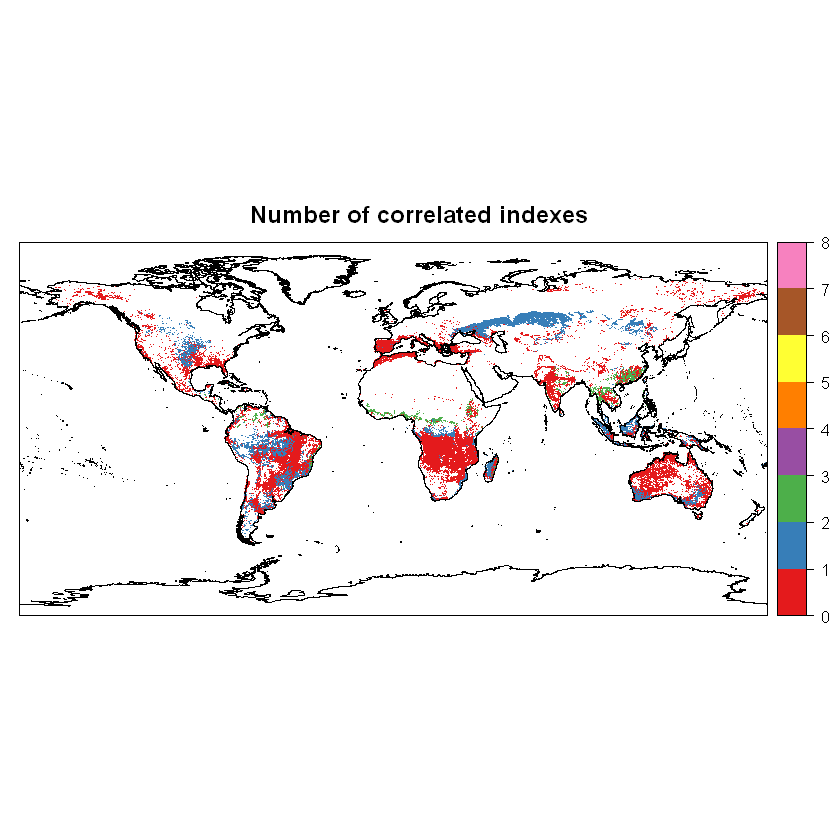

In [15]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Number of correlated indexes')

v = cbind(as.numeric(corr.df.delta$nao.pvalue<0.05), as.numeric(corr.df.delta$poleur.pvalue<0.05), as.numeric(corr.df.delta$ea.pvalue<0.05),
          as.numeric(corr.df.delta$eawr.pvalue<0.05), as.numeric(corr.df.delta$pna.pvalue<0.05), as.numeric(corr.df.delta$nina34.pvalue<0.05), 
          as.numeric(corr.df.delta$scand.pvalue<0.05), as.numeric(corr.df.delta$wp.pvalue<0.05))

suma = rowSums(v, na.rm=T)
v <- suma
v[which(v < 1)] <- NA

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

for (i in 1:8){
    cat('Number of pixels correlated with more than ', i-1, ' indexes ', sum(suma > i-1), '\n')
}

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

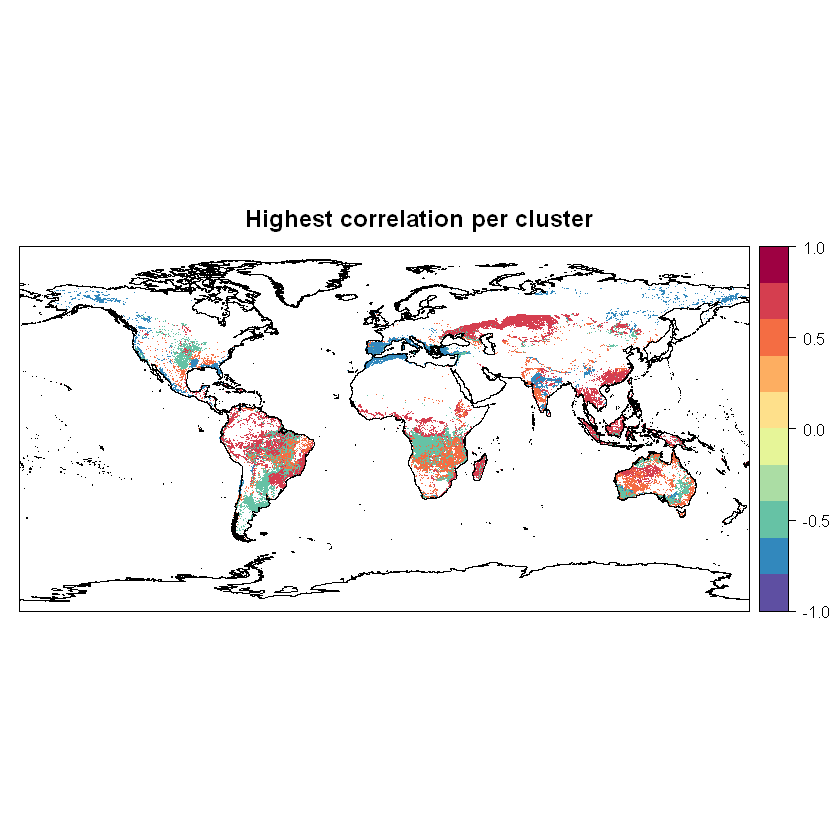

In [17]:
arg.list <- list(col.regions = group.colors[11:1][-6],
                      at = seq(-1, 1, 0.2), main = 'Highest correlation per cluster')

v = apply(corr.df.delta, 1, function (x) getMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
f2 = do.call("spplot", arg.list)
print(f2)

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

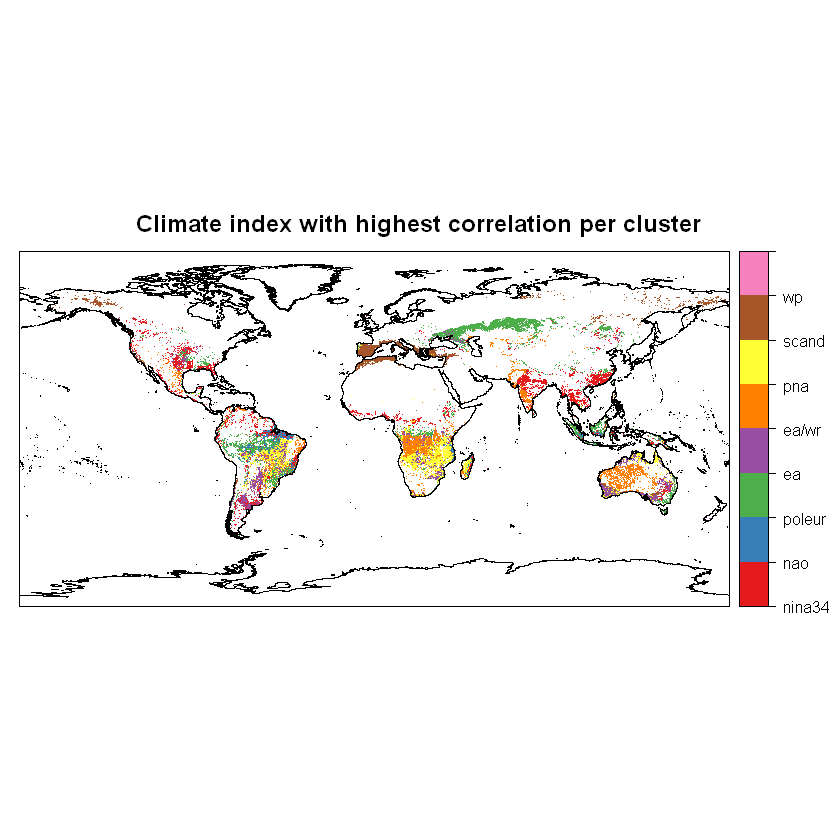

In [18]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Climate index with highest correlation per cluster')
v = apply(corr.df.delta, 1, function (x) getIndWithMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["colorkey"]] <- list(labels = list(labels = c("nina34", "nao", "poleur", "ea", "ea/wr", "pna", "scand", "wp","")))
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

## With 1-month persistence

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

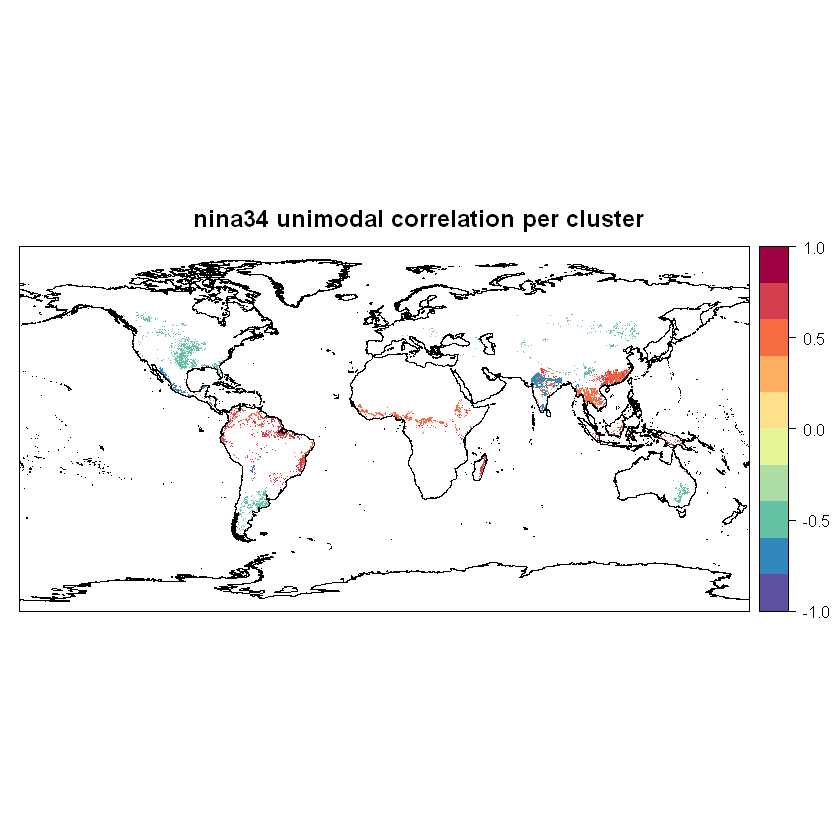

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

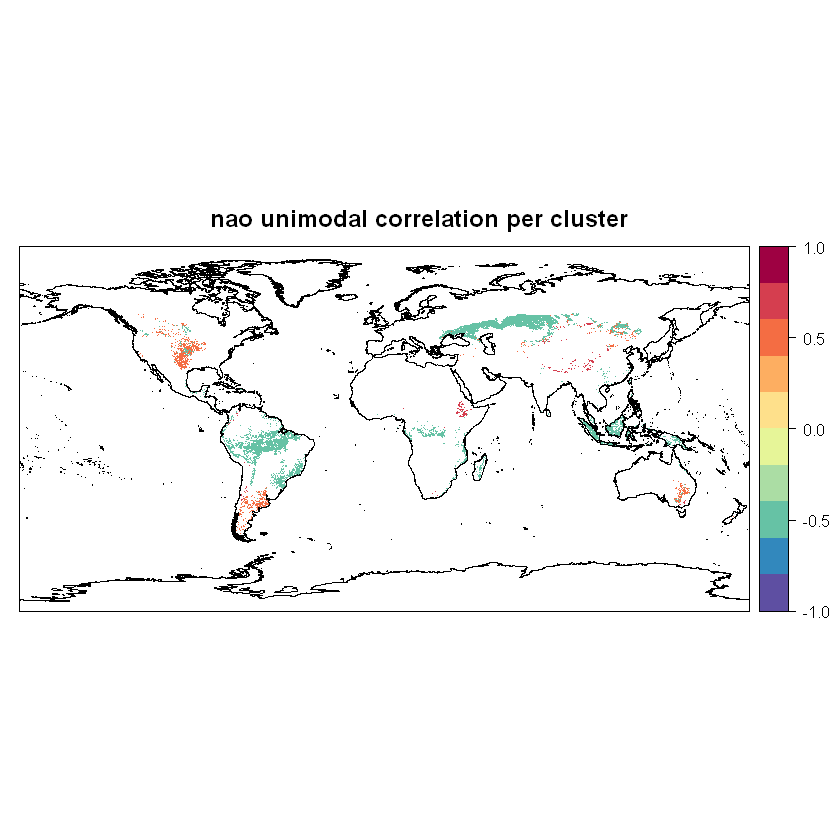

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

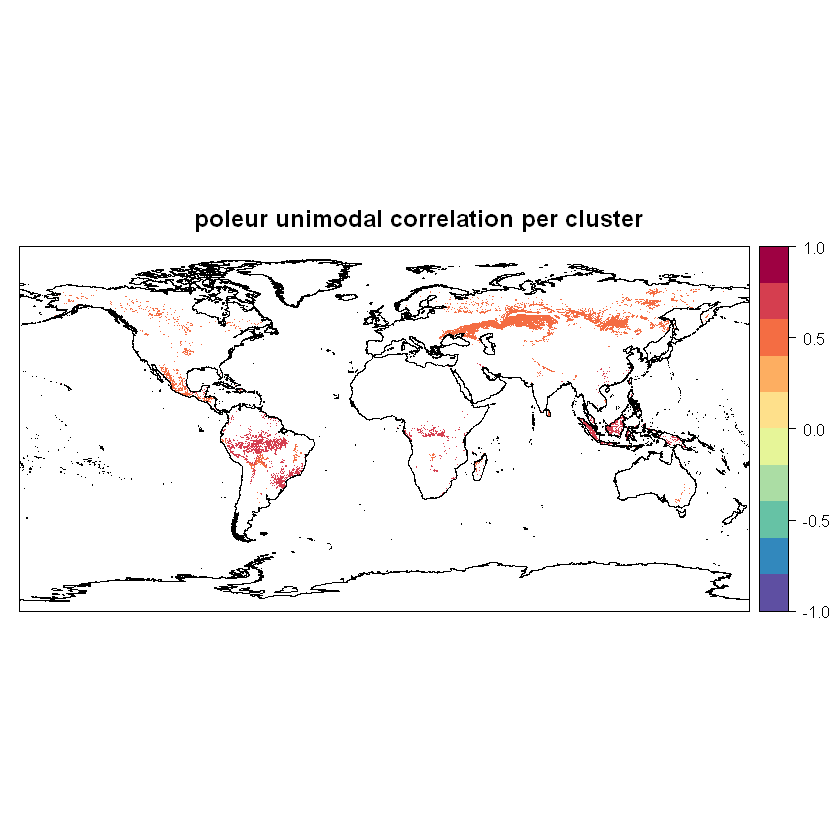

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

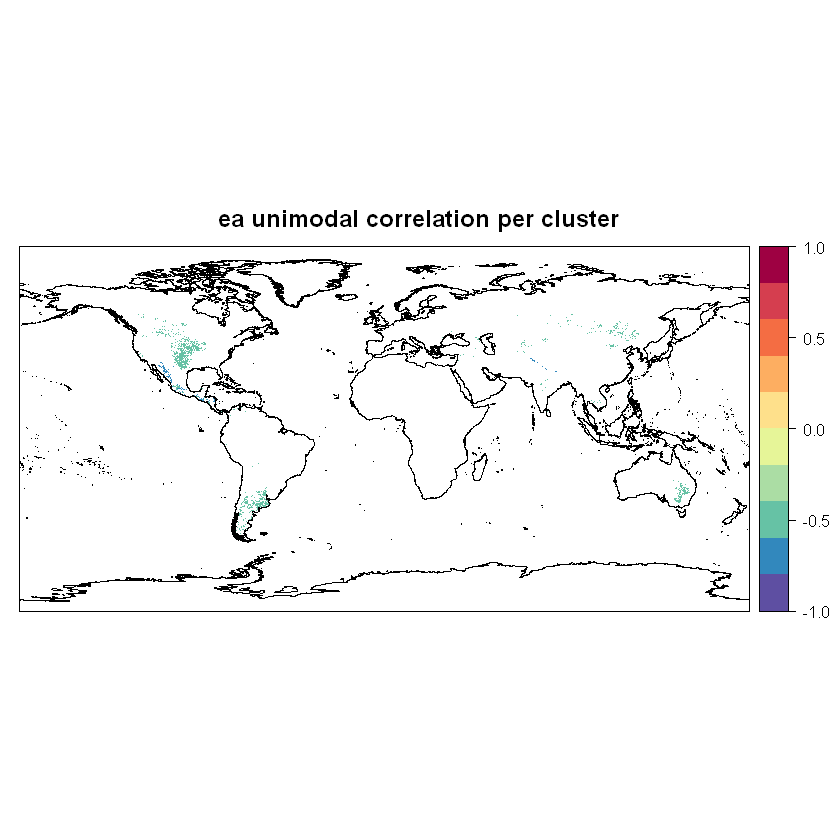

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

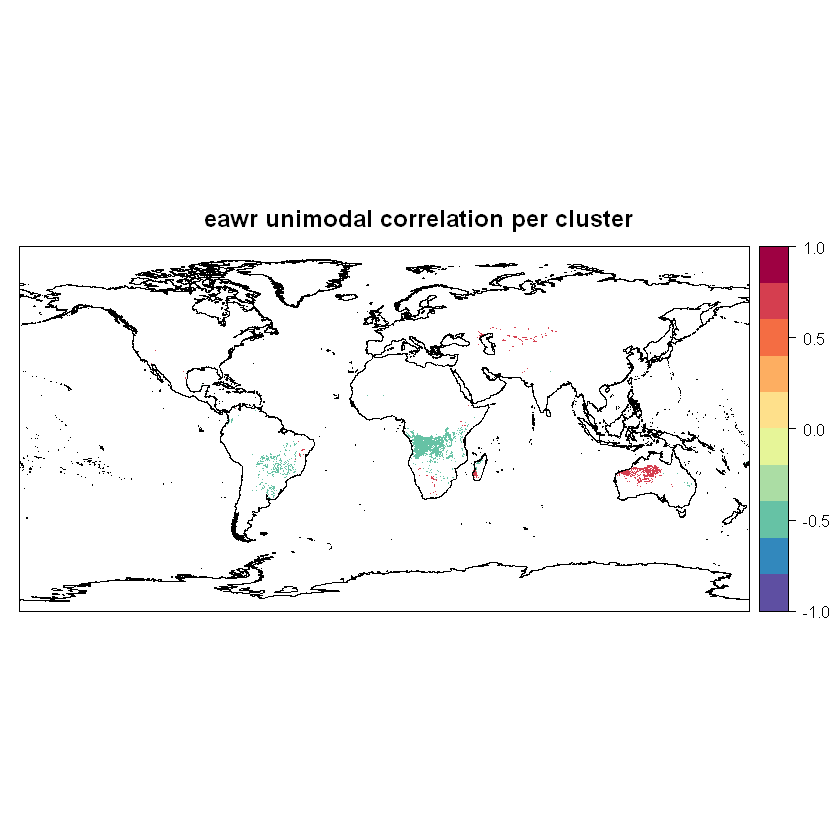

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

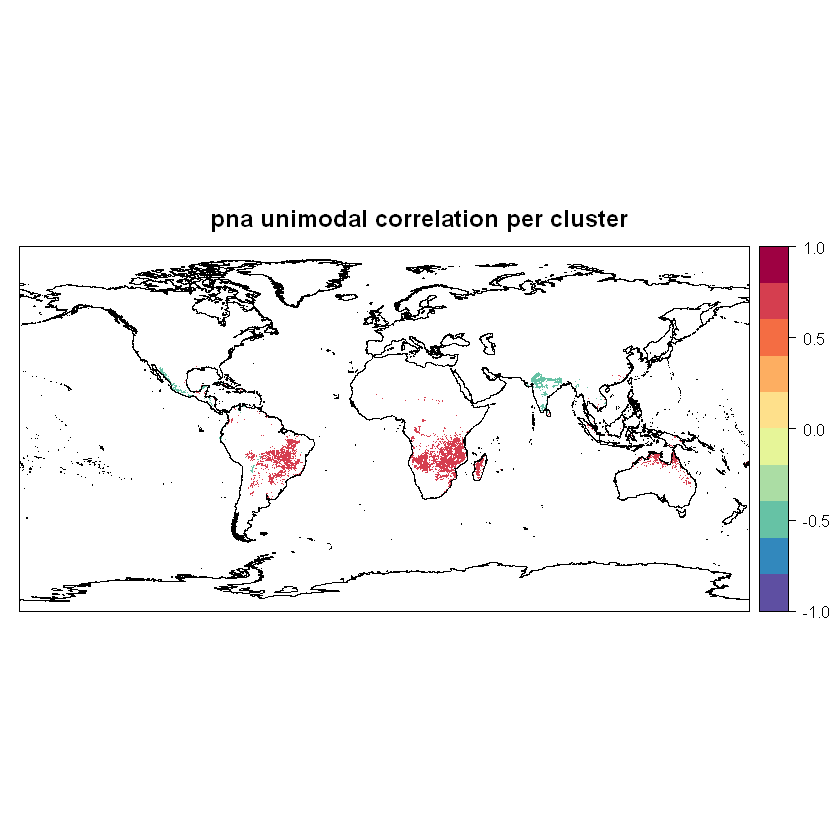

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

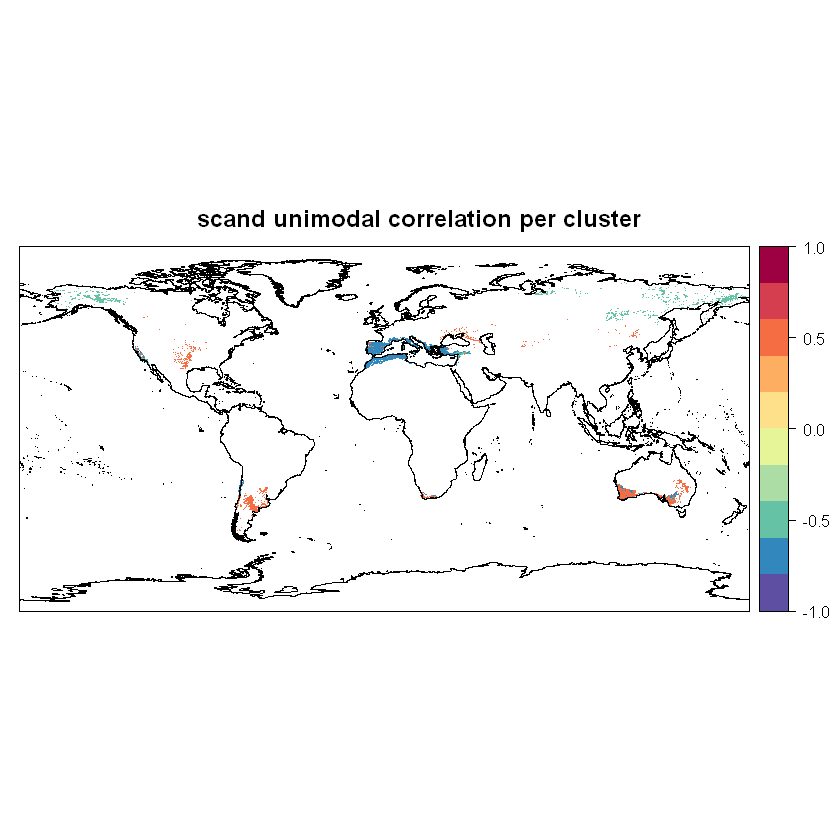

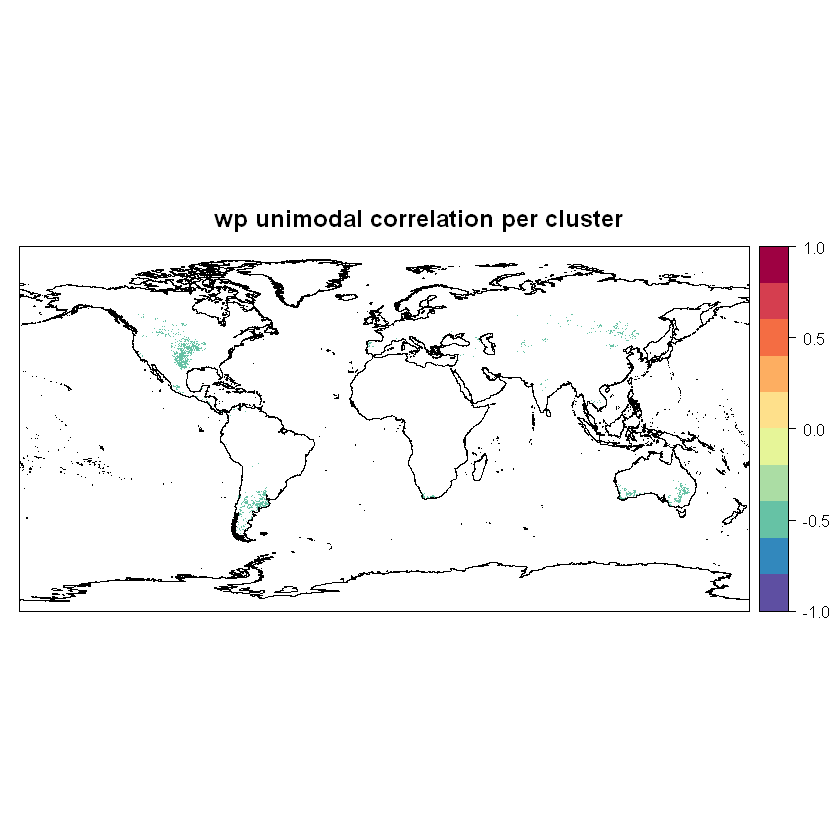

In [13]:
corr.df.delta.1 = masked_coords
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nina34, 'nina34',
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nao, 'nao', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, poleur, 'poleur',
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, ea, 'ea', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, eawr, 'eawr', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, pna, 'pna', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, scand, 'scand', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)
corr.df.delta.1 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, wp, 'wp', 
                           corr.df.delta.1, mode = 'unimodal', useDeltas = T, t = 1)

save(corr.df.delta.1, file = 'data/Correlation/corrDfDeltaAnnualClusLag1V2.Rdata')

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

Number of pixels correlated with more than  0  indexes  47262 
Number of pixels correlated with more than  1  indexes  13470 
Number of pixels correlated with more than  2  indexes  2163 
Number of pixels correlated with more than  3  indexes  2163 
Number of pixels correlated with more than  4  indexes  0 
Number of pixels correlated with more than  5  indexes  0 
Number of pixels correlated with more than  6  indexes  0 
Number of pixels correlated with more than  7  indexes  0 


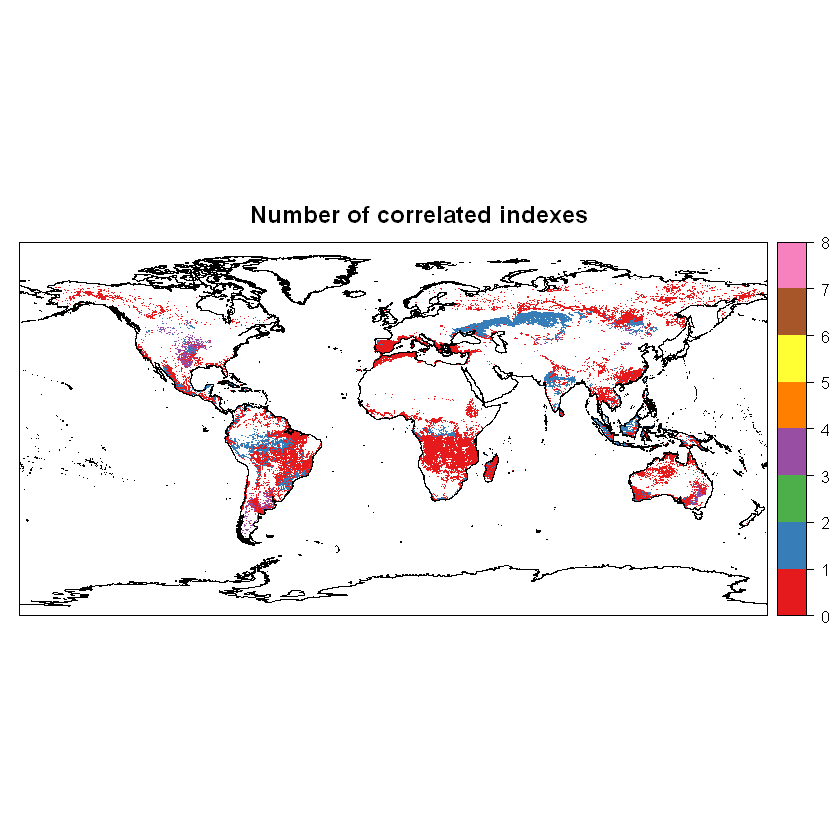

In [20]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Number of correlated indexes')

v = cbind(as.numeric(corr.df.delta.1$nao.pvalue<0.05), as.numeric(corr.df.delta.1$poleur.pvalue<0.05), as.numeric(corr.df.delta.1$ea.pvalue<0.05),
          as.numeric(corr.df.delta.1$eawr.pvalue<0.05), as.numeric(corr.df.delta.1$pna.pvalue<0.05), as.numeric(corr.df.delta.1$nina34.pvalue<0.05), 
          as.numeric(corr.df.delta.1$scand.pvalue<0.05), as.numeric(corr.df.delta.1$wp.pvalue<0.05))

suma = rowSums(v, na.rm=T)
v <- suma
v[which(v < 1)] <- NA

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

for (i in 1:8){
    cat('Number of pixels correlated with more than ', i-1, ' indexes ', sum(suma > i-1), '\n')
}

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

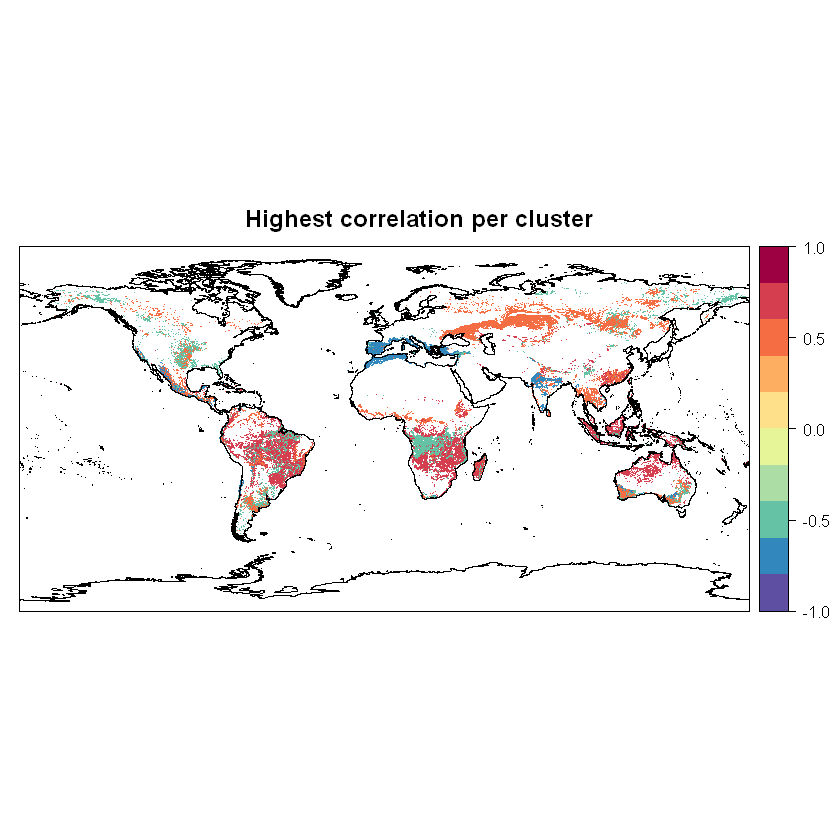

In [21]:
arg.list <- list(col.regions = group.colors[11:1][-6],
                      at = seq(-1, 1, 0.2), main = 'Highest correlation per cluster')

v = apply(corr.df.delta.1, 1, function (x) getMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

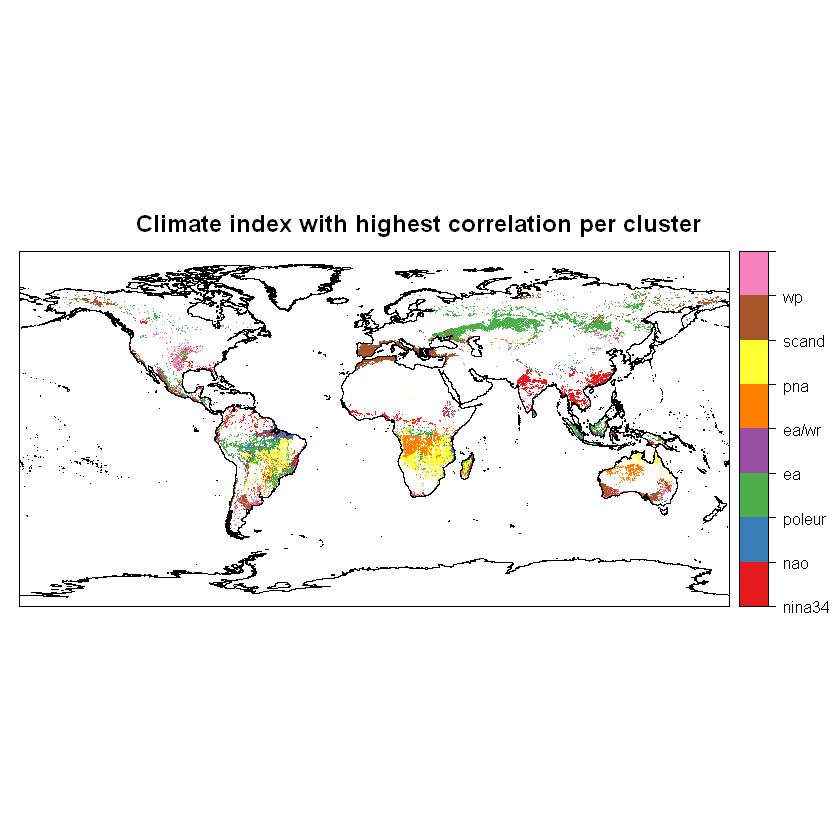

In [22]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Climate index with highest correlation per cluster')
v = apply(corr.df.delta.1, 1, function (x) getIndWithMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["colorkey"]] <- list(labels = list(labels = c("nina34", "nao", "poleur", "ea", "ea/wr", "pna", "scand", "wp","")))
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

## With 2-months persistence

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

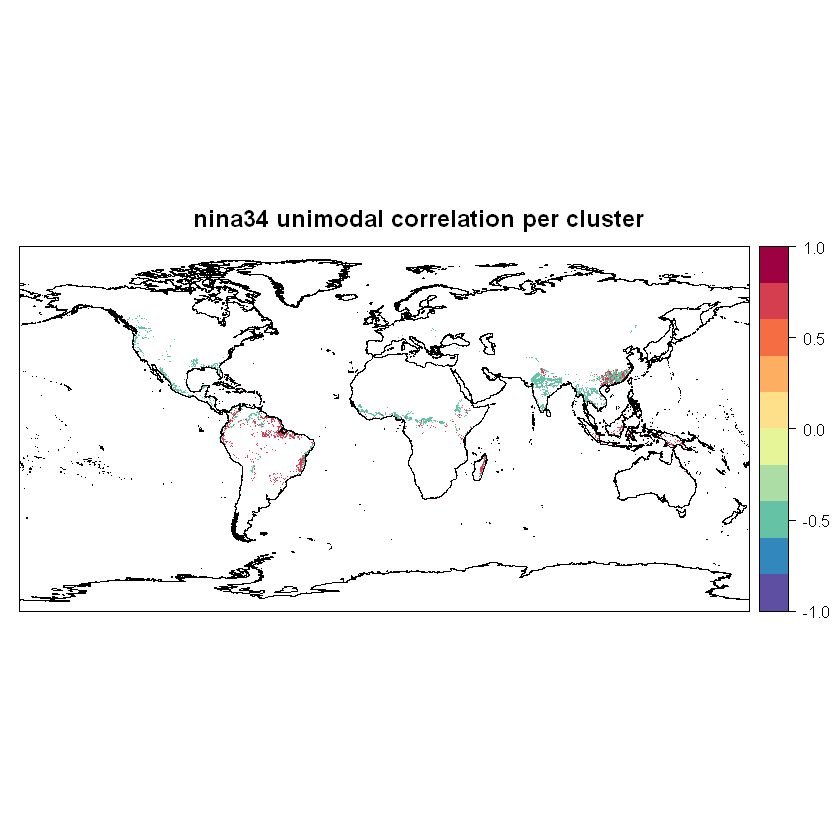

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

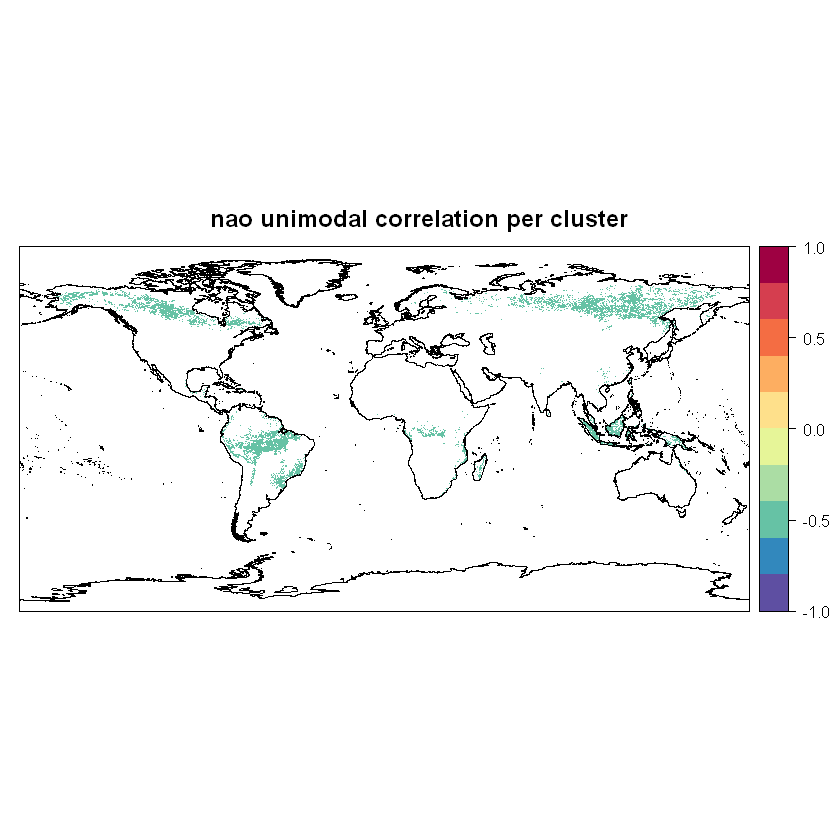

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

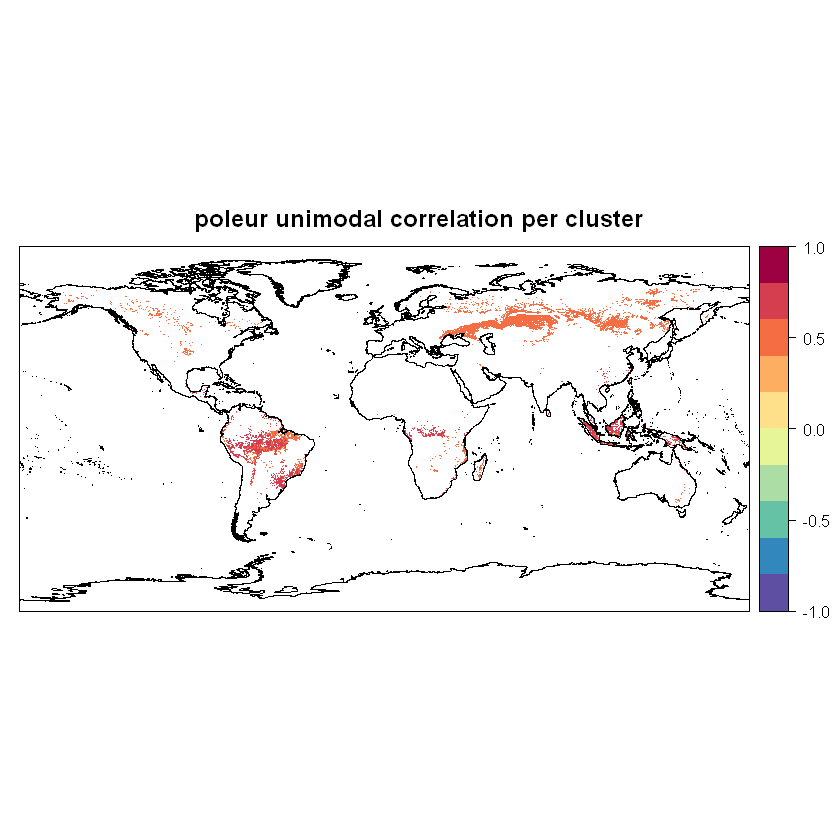

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

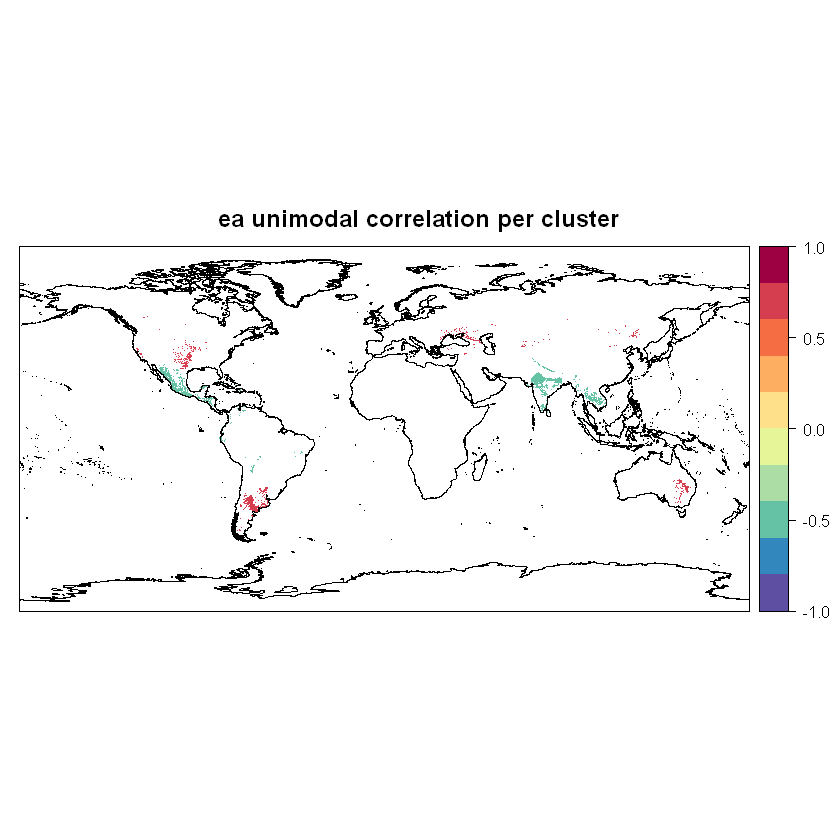

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

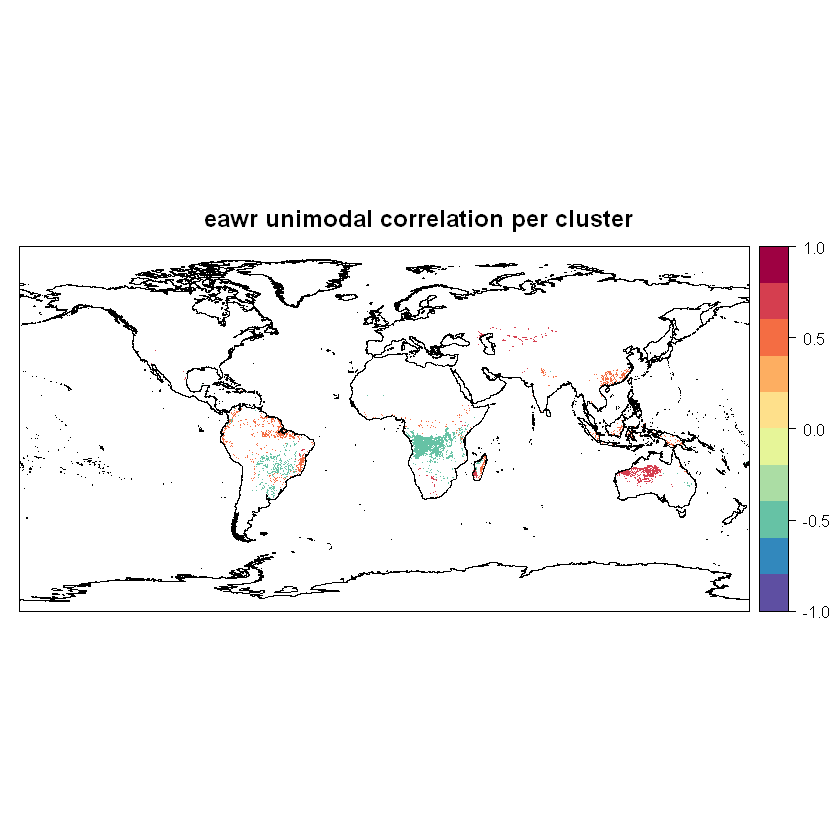

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

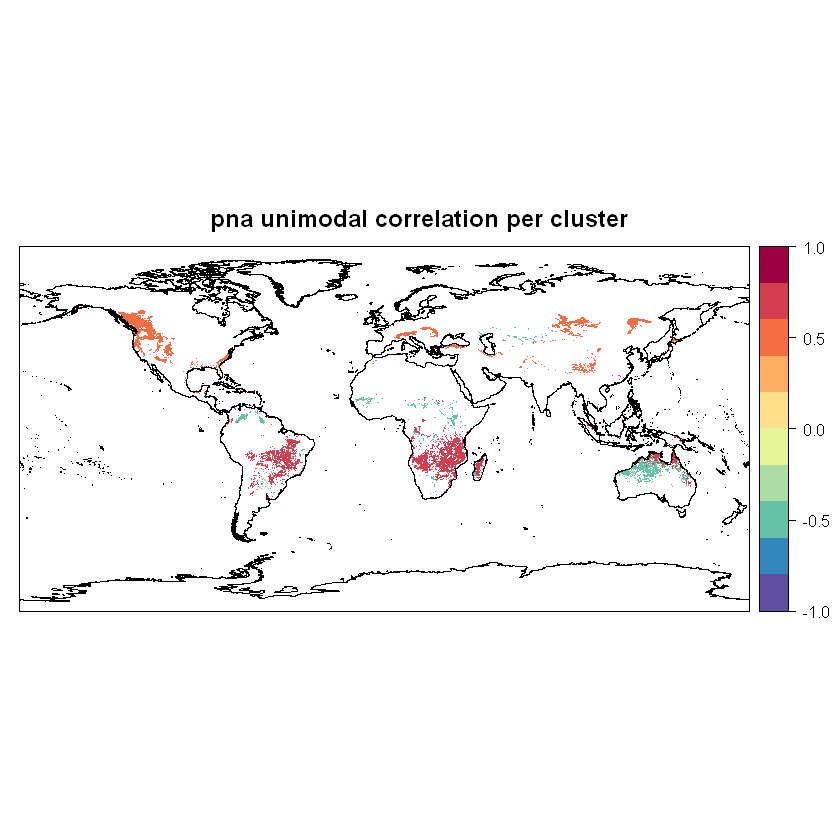

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

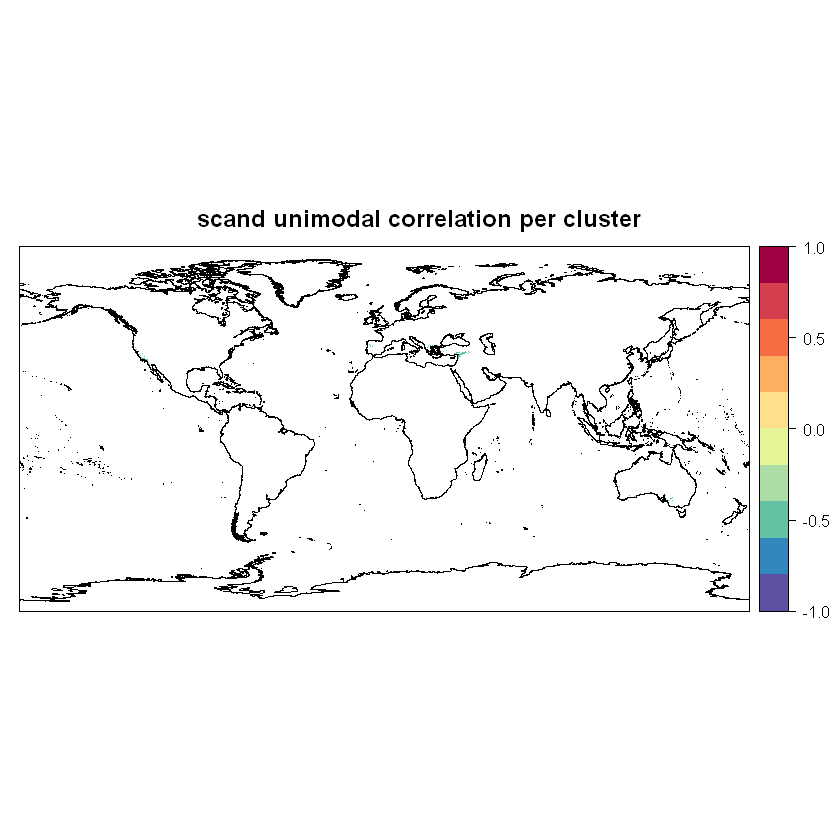

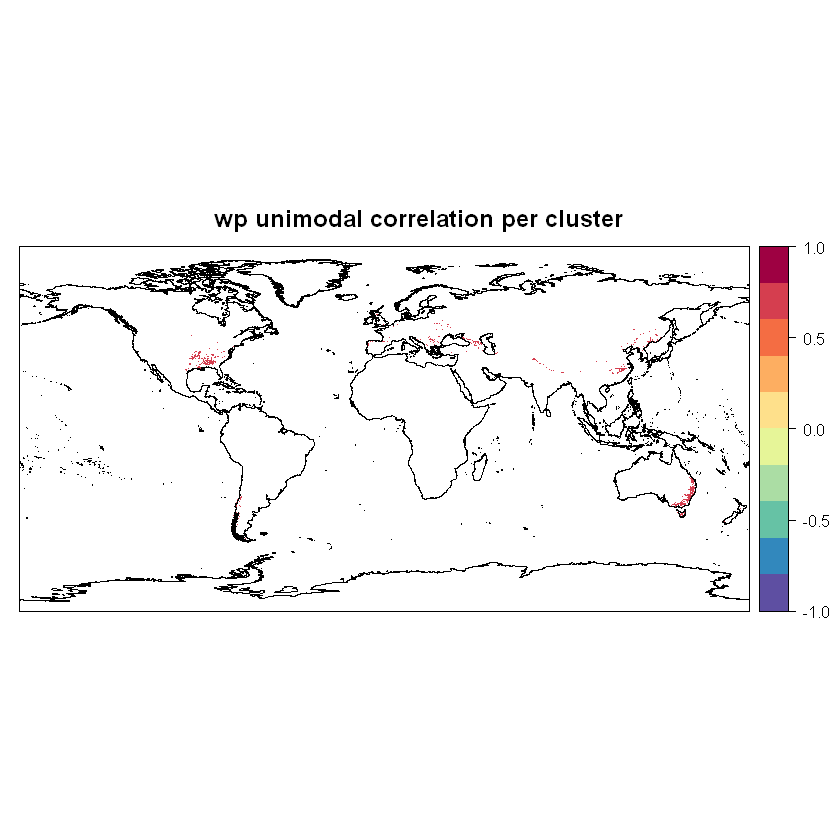

In [14]:
corr.df.delta.2 = masked_coords
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nina34, 'nina34',
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nao, 'nao', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, poleur, 'poleur',
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, ea, 'ea', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, eawr, 'eawr', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, pna, 'pna', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, scand, 'scand', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)
corr.df.delta.2 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, wp, 'wp', 
                           corr.df.delta.2, mode = 'unimodal', useDeltas = T, t = 2)

save(corr.df.delta.2, file = 'data/Correlation/corrDfDeltaAnnualClusLag2V2.Rdata')

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

Number of pixels correlated with more than  0  indexes  55245 
Number of pixels correlated with more than  1  indexes  11616 
Number of pixels correlated with more than  2  indexes  0 
Number of pixels correlated with more than  3  indexes  0 
Number of pixels correlated with more than  4  indexes  0 
Number of pixels correlated with more than  5  indexes  0 
Number of pixels correlated with more than  6  indexes  0 
Number of pixels correlated with more than  7  indexes  0 


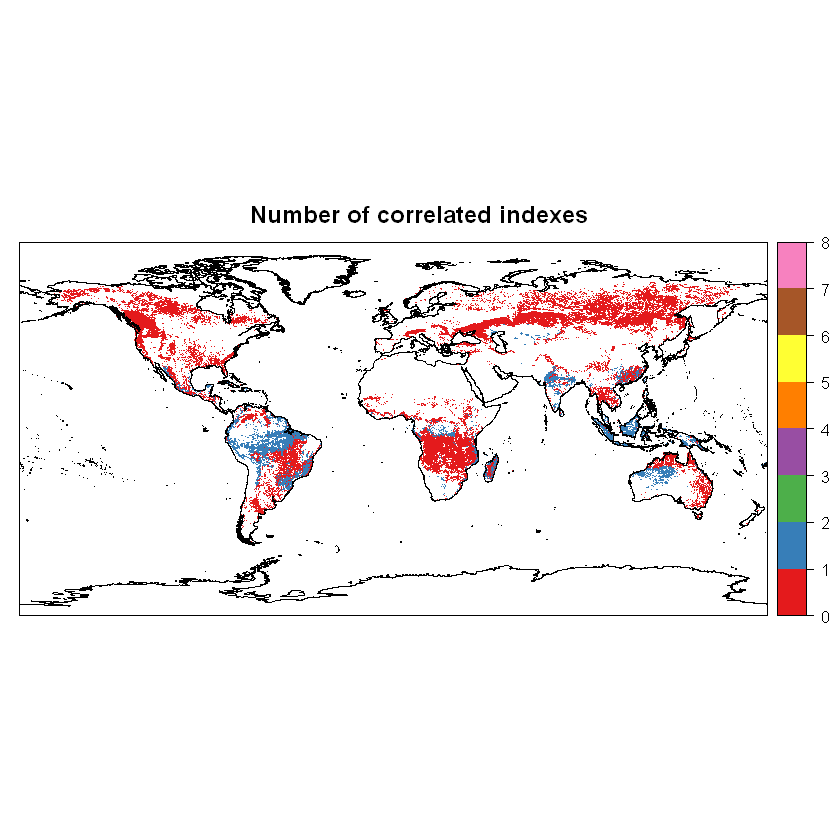

In [24]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Number of correlated indexes')

v = cbind(as.numeric(corr.df.delta.2$nao.pvalue<0.05), as.numeric(corr.df.delta.2$poleur.pvalue<0.05), as.numeric(corr.df.delta.2$ea.pvalue<0.05),
          as.numeric(corr.df.delta.2$eawr.pvalue<0.05), as.numeric(corr.df.delta.2$pna.pvalue<0.05), as.numeric(corr.df.delta.2$nina34.pvalue<0.05), 
          as.numeric(corr.df.delta.2$scand.pvalue<0.05), as.numeric(corr.df.delta.2$wp.pvalue<0.05))

suma = rowSums(v, na.rm=T)
v <- suma
v[which(v < 1)] <- NA

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

for (i in 1:8){
    cat('Number of pixels correlated with more than ', i-1, ' indexes ', sum(suma > i-1), '\n')
}

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

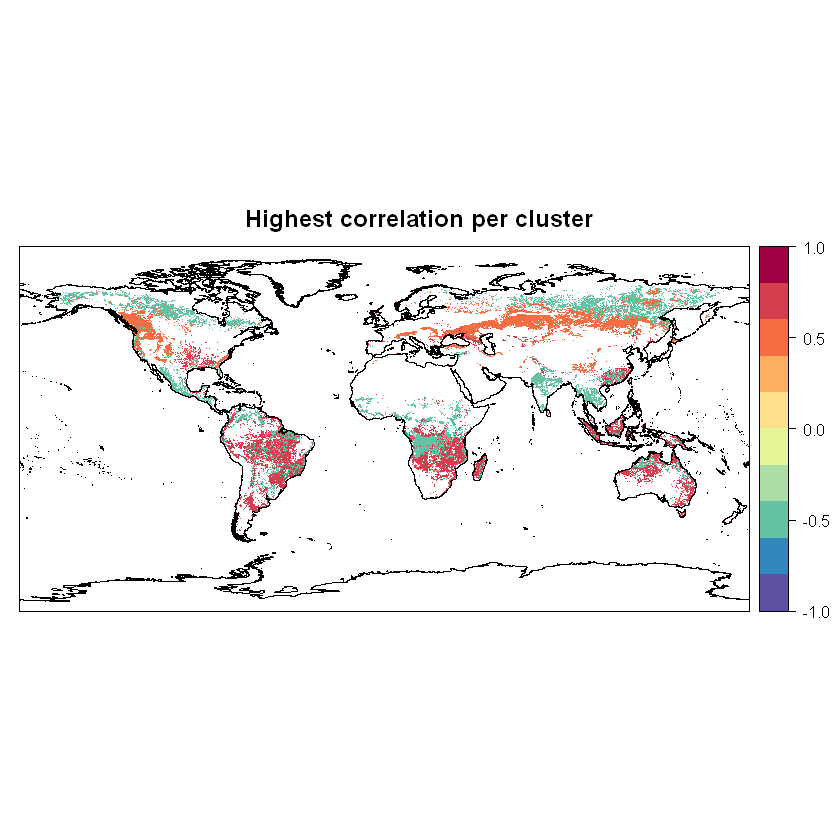

In [25]:
arg.list <- list(col.regions = group.colors[11:1][-6],
                      at = seq(-1, 1, 0.2), main = 'Highest correlation per cluster')

v = apply(corr.df.delta.2, 1, function (x) getMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

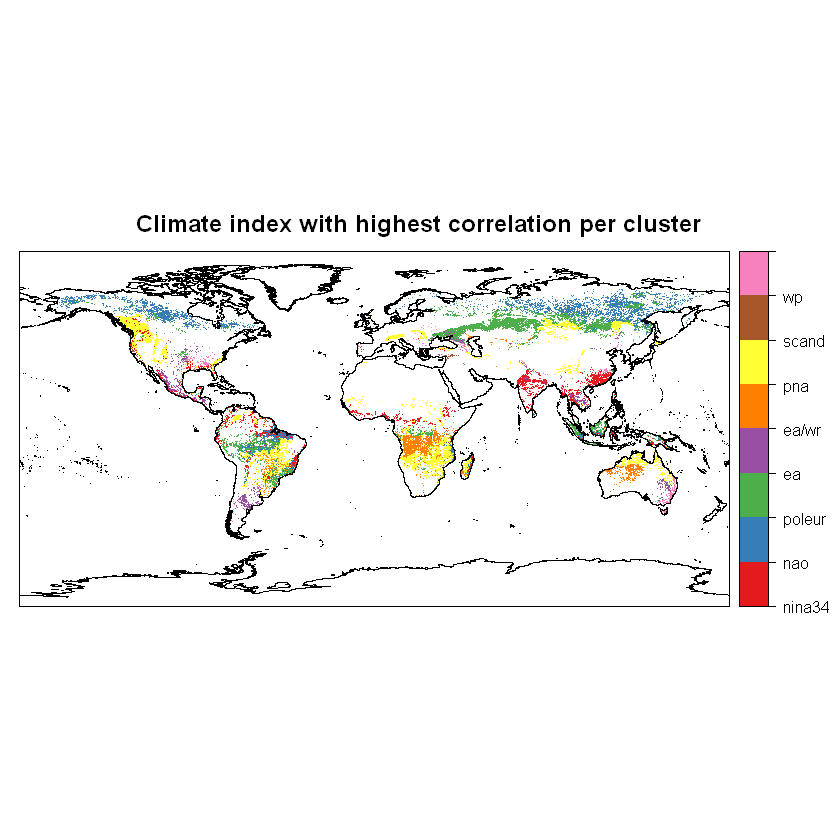

In [26]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Climate index with highest correlation per cluster')
v = apply(corr.df.delta.2, 1, function (x) getIndWithMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["colorkey"]] <- list(labels = list(labels = c("nina34", "nao", "poleur", "ea", "ea/wr", "pna", "scand", "wp","")))
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

## With 3-months persistence

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

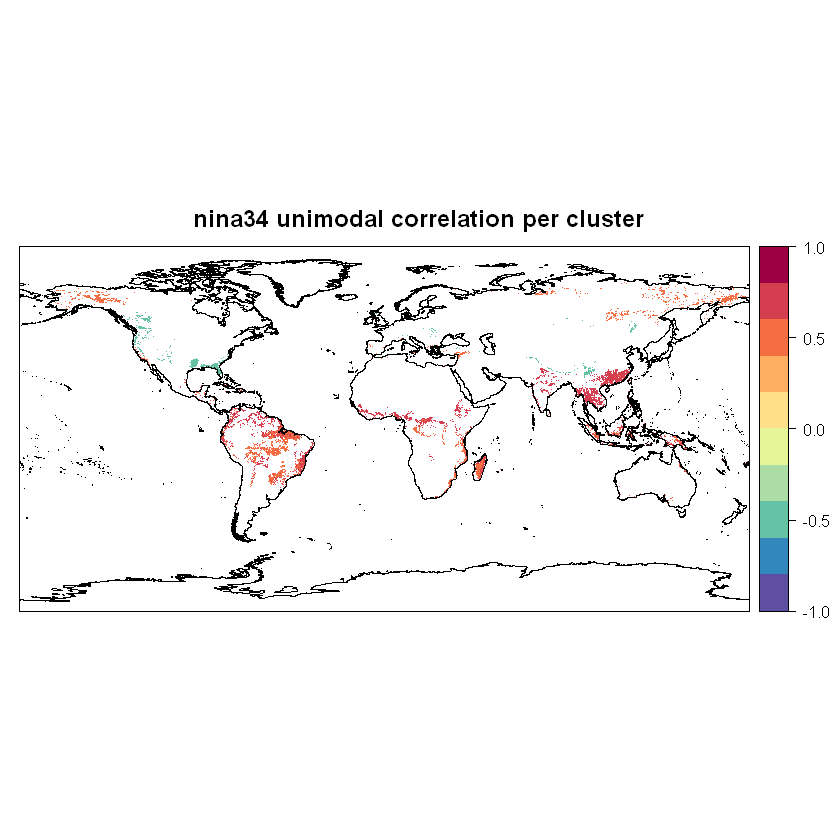

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

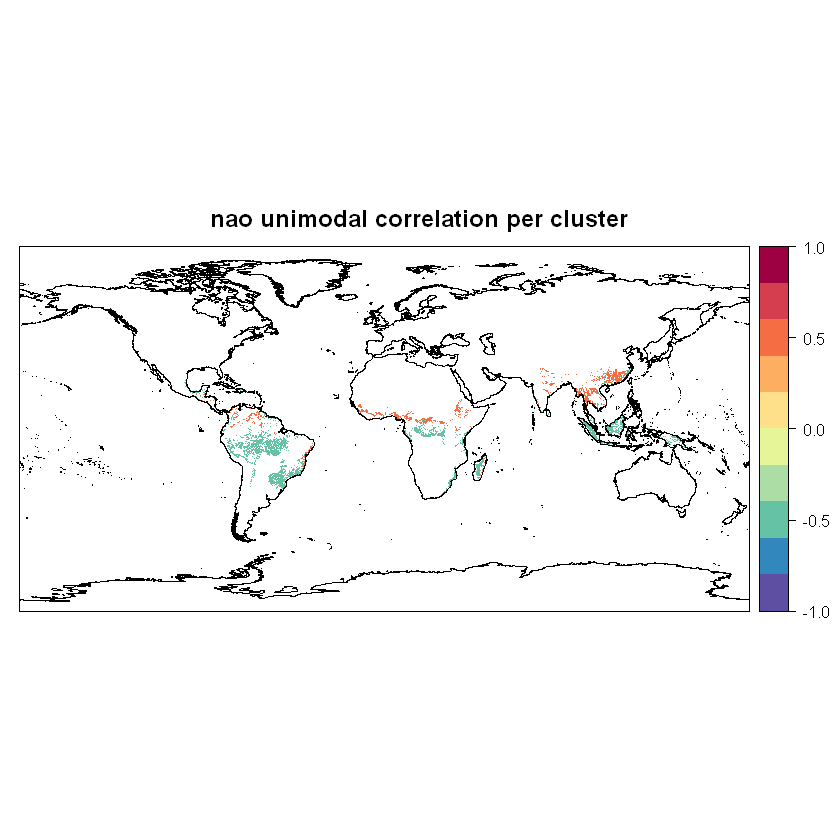

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

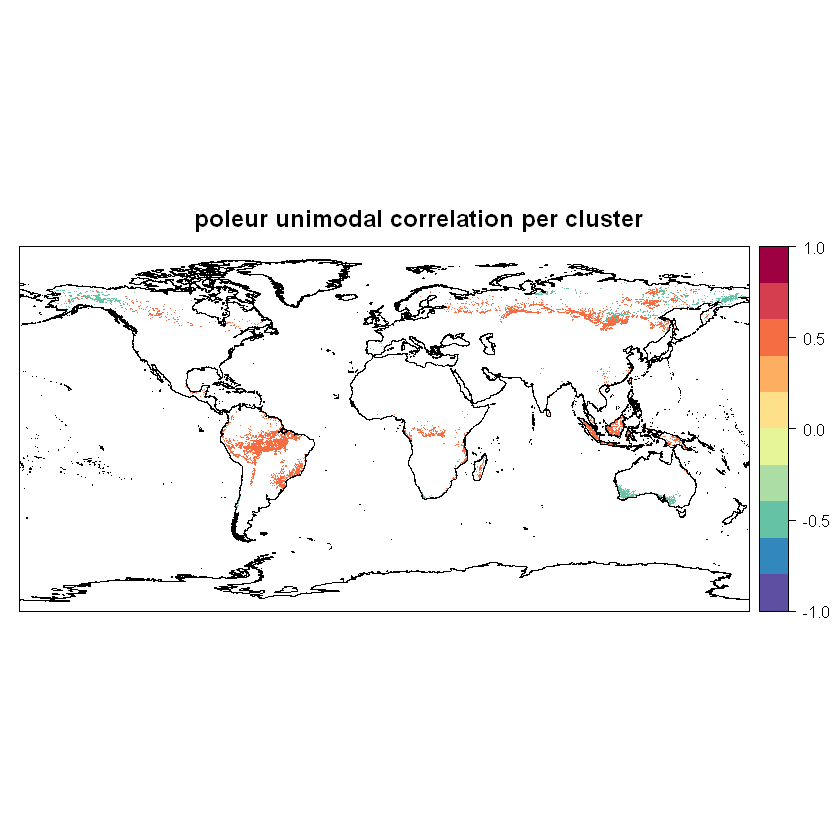

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

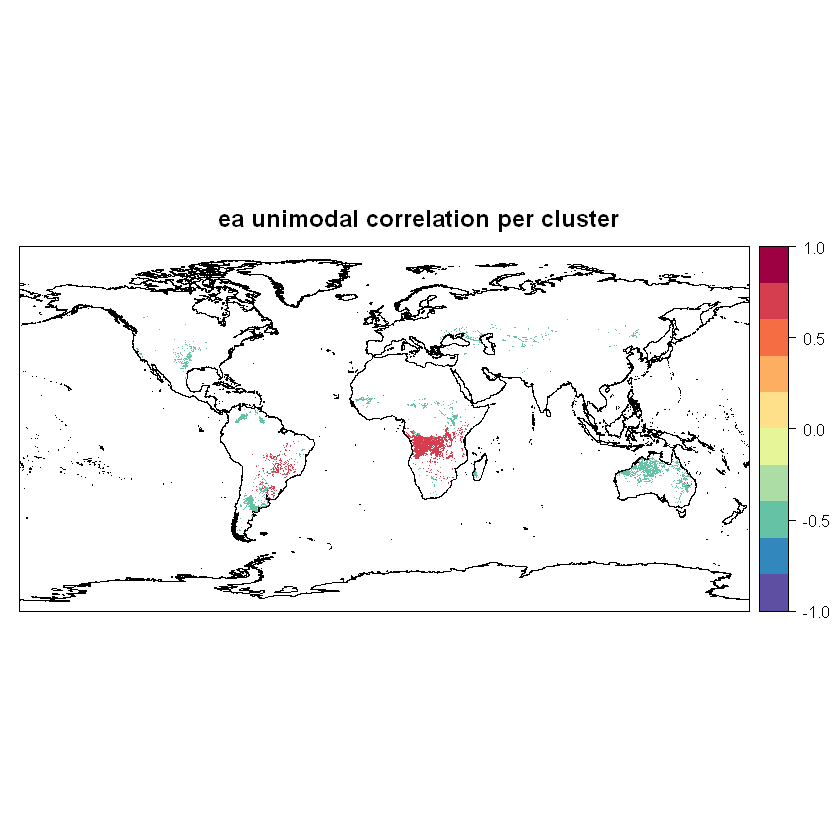

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

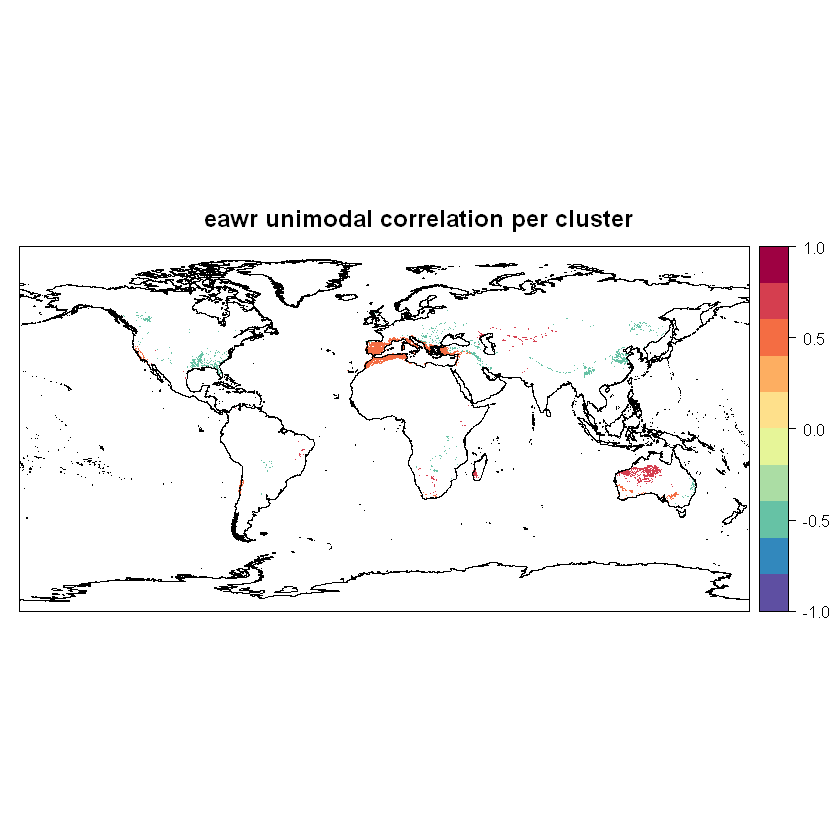

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

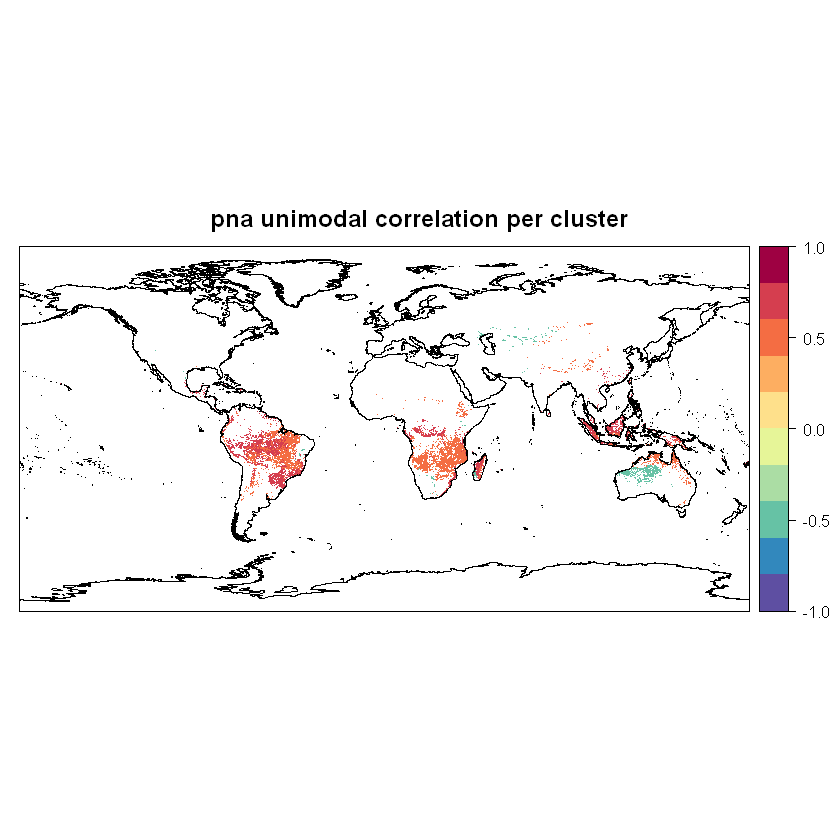

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"Warning message in min(x):
"ningún argumento finito para min; retornando Inf"Warning message in max(x):
"ningun argumento finito para max; retornando -Inf"Warning message in min(x):
"ningún argumento finito para min; retornando Inf"Warning message in max(x):
"ningun argumento finito para max; retornando -Inf"

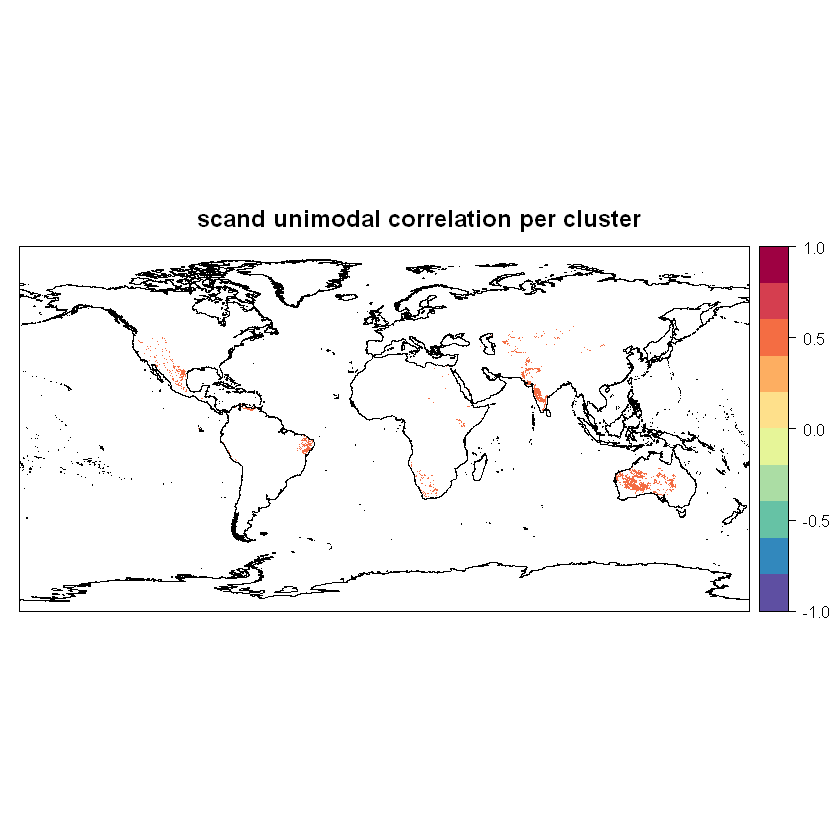

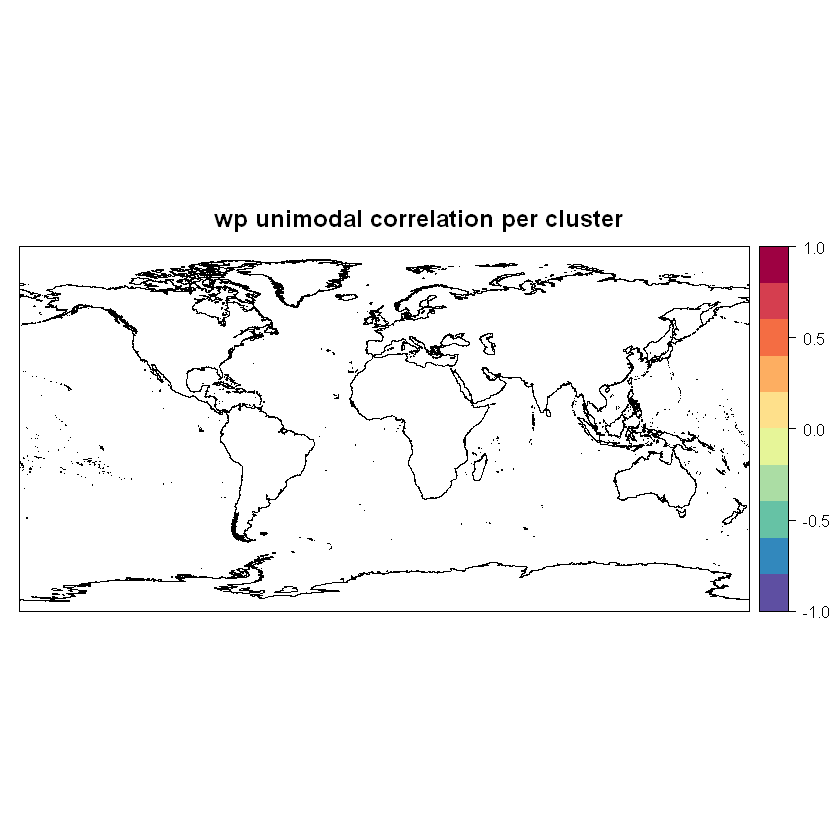

In [15]:
corr.df.delta.3 = masked_coords
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nina34, 'nina34',
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, nao, 'nao', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, poleur, 'poleur',
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, ea, 'ea', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, eawr, 'eawr', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, pna, 'pna', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, scand, 'scand', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)
corr.df.delta.3 = corr.annual.clus(log1p(masked_ba_series), fireSeason_def_2, masked_coords, dates, wp, 'wp', 
                           corr.df.delta.3, mode = 'unimodal', useDeltas = T, t = 3)

save(corr.df.delta.3, file = 'data/Correlation/corrDfDeltaAnnualClusLag3V2.Rdata')

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

Number of pixels correlated with more than  0  indexes  43498 
Number of pixels correlated with more than  1  indexes  14427 
Number of pixels correlated with more than  2  indexes  9014 
Number of pixels correlated with more than  3  indexes  0 
Number of pixels correlated with more than  4  indexes  0 
Number of pixels correlated with more than  5  indexes  0 
Number of pixels correlated with more than  6  indexes  0 
Number of pixels correlated with more than  7  indexes  0 


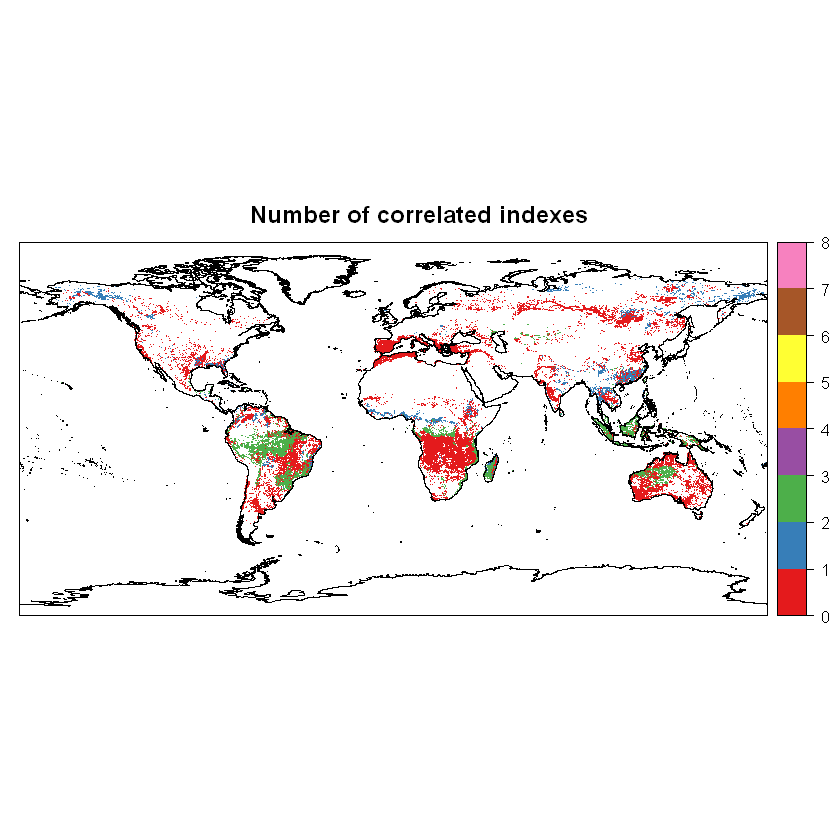

In [28]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Number of correlated indexes')

v = cbind(as.numeric(corr.df.delta.3$nao.pvalue<0.05), as.numeric(corr.df.delta.3$poleur.pvalue<0.05), as.numeric(corr.df.delta.3$ea.pvalue<0.05),
          as.numeric(corr.df.delta.3$eawr.pvalue<0.05), as.numeric(corr.df.delta.3$pna.pvalue<0.05), as.numeric(corr.df.delta.3$nina34.pvalue<0.05), 
          as.numeric(corr.df.delta.3$scand.pvalue<0.05), as.numeric(corr.df.delta.3$wp.pvalue<0.05))

suma = rowSums(v, na.rm=T)
v <- suma
v[which(v < 1)] <- NA

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

for (i in 1:8){
    cat('Number of pixels correlated with more than ', i-1, ' indexes ', sum(suma > i-1), '\n')
}

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

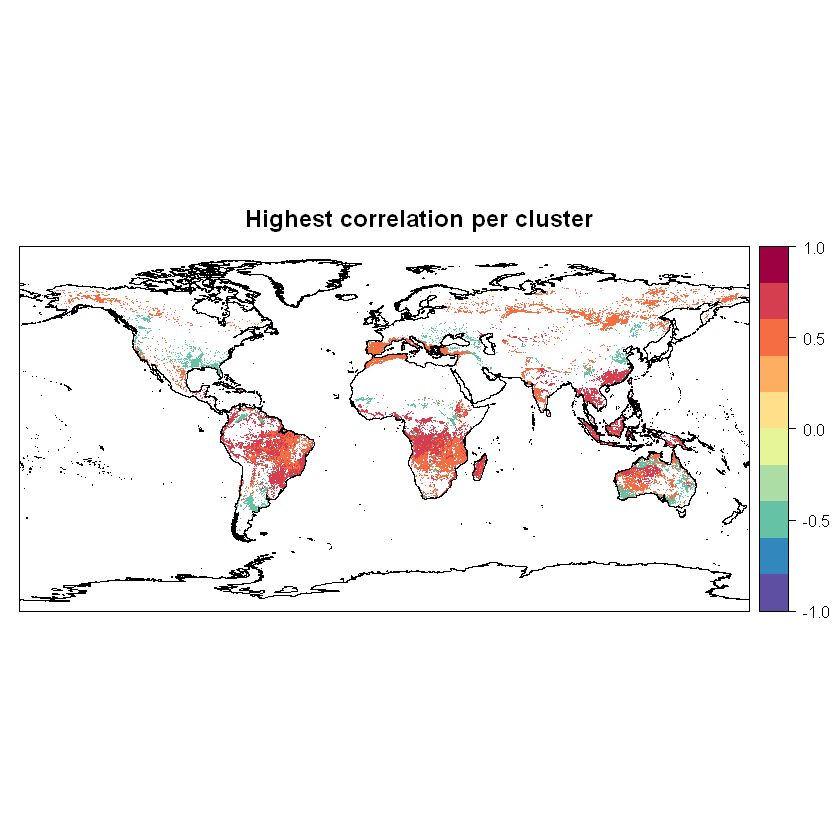

In [29]:
arg.list <- list(col.regions = group.colors[11:1][-6],
                      at = seq(-1, 1, 0.2), main = 'Highest correlation per cluster')

v = apply(corr.df.delta.3, 1, function (x) getMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

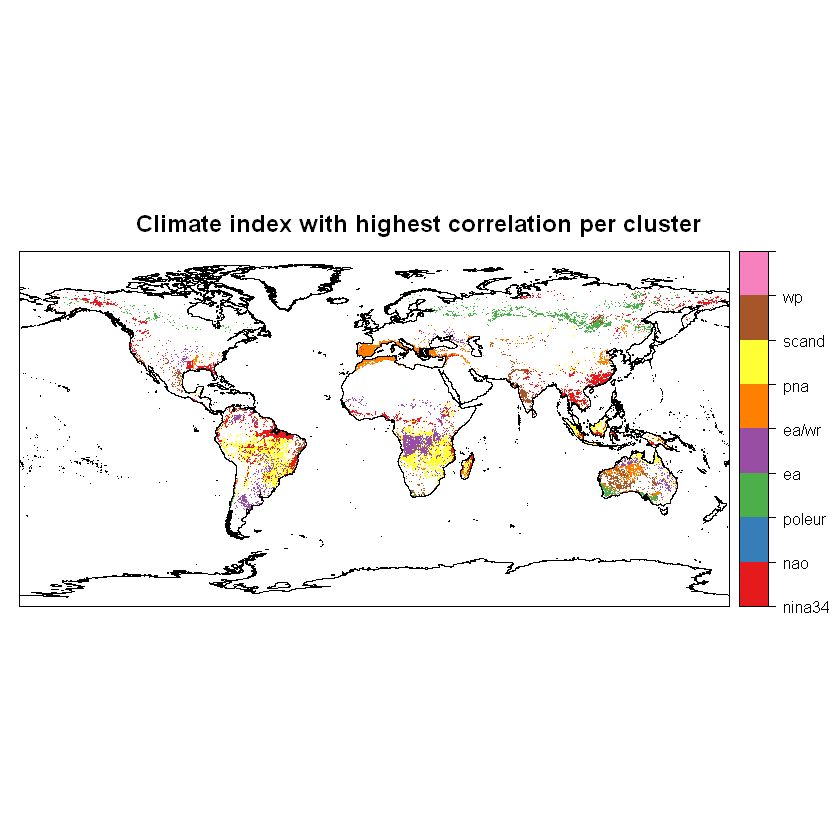

In [30]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Climate index with highest correlation per cluster')
v = apply(corr.df.delta.3, 1, function (x) getIndWithMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["colorkey"]] <- list(labels = list(labels = c("nina34", "nao", "poleur", "ea", "ea/wr", "pna", "scand", "wp","")))
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

## Combining all

We show two plots summarizing the obtained results.

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

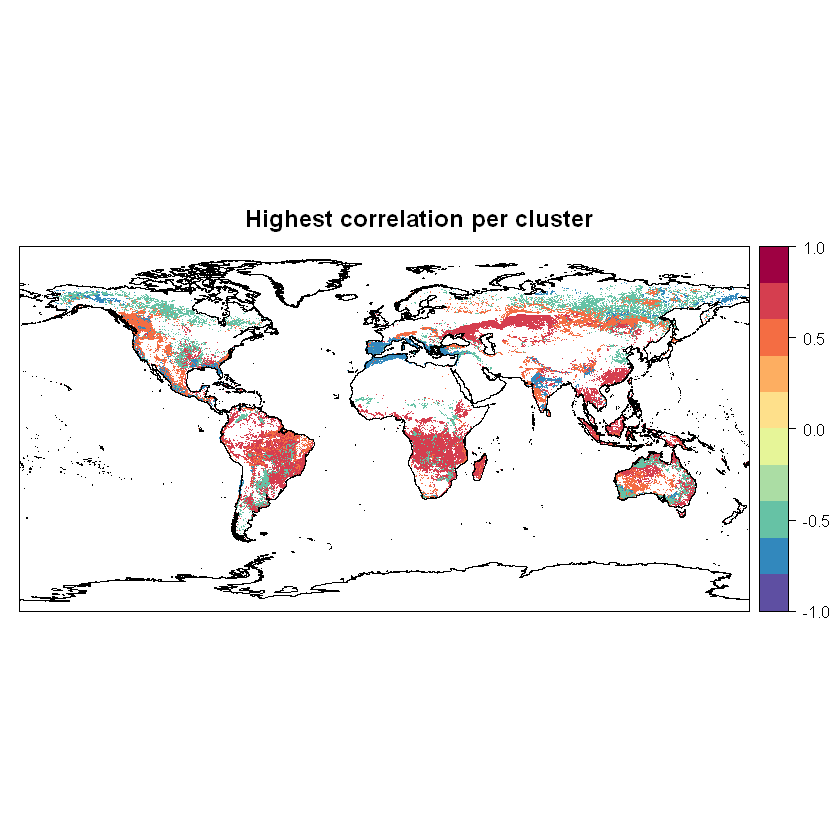

In [31]:
arg.list <- list(col.regions = group.colors[11:1][-6],
                      at = seq(-1, 1, 0.2), main = 'Highest correlation per cluster')

v = apply(cbind(corr.df.delta, corr.df.delta.1[,-c(1,2)], corr.df.delta.2[,-c(1,2)], corr.df.delta.3[,-c(1,2)]), 1,
          function (x) getMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()

Warning message in points2grid(points, tolerance, round):
"grid has empty column/rows in dimension 1"

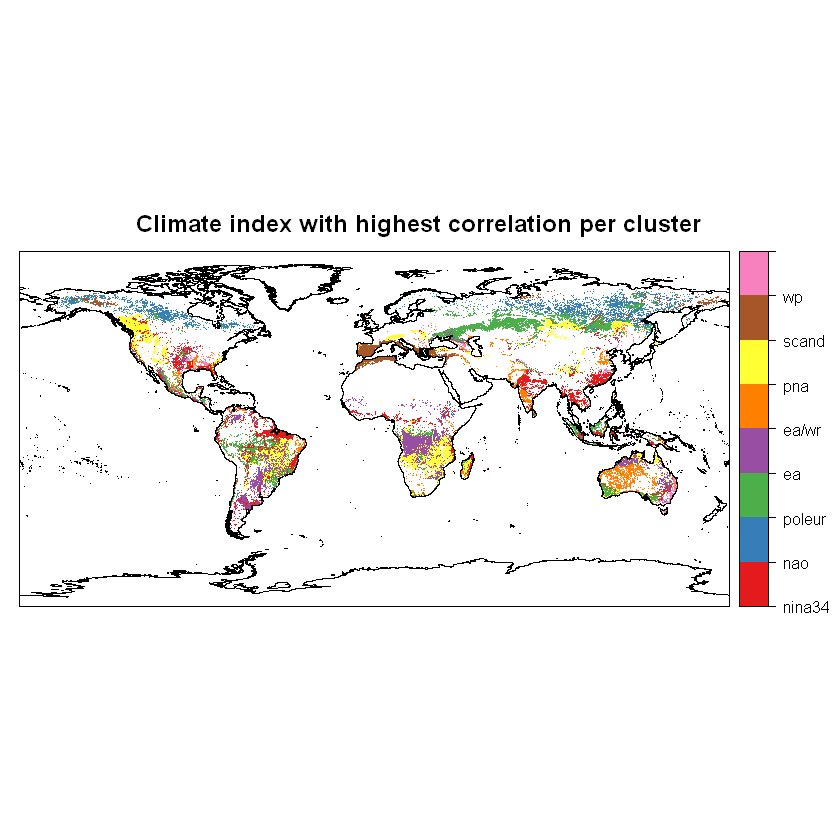

In [32]:
arg.list <- list(col.regions = brewer.pal(8, 'Set1'),
                          at = seq(0, 8, 1), main = 'Climate index with highest correlation per cluster')
v = apply(cbind(corr.df.delta, corr.df.delta.1[,-c(1,2)], corr.df.delta.2[,-c(1,2)], corr.df.delta.3[,-c(1,2)]), 1,
          function (x) getIndWithMaxCorr(x))

df1 <- cbind.data.frame(masked_coords, v)
coordinates(df1) <- c(1,2)
gridded(df1) <- TRUE
arg.list[["sp.layout"]] <- list("sp.lines", coast.lines)
arg.list[["obj"]] <- df1
arg.list[["colorkey"]] <- list(labels = list(labels = c("nina34", "nao", "poleur", "ea", "ea/wr", "pna", "scand", "wp","")))
arg.list[["zcol"]] <- 1
arg.list[["ylim"]] <- c(-90,90)
arg.list[["xlim"]] <- c(-180,180)
do.call("spplot", arg.list) %>% print()